# Assignment 1
**Credits**: Federico Ruggeri, Eleonora Mancini, Paolo Torroni

**Keywords**: Sexism Detection, Multi-class Classification, RNNs, Transformers, Huggingface



# Contact
For any doubt, question, issue or help, you can always contact us at the following email addresses:

Teaching Assistants:

- Federico Ruggeri -> federico.ruggeri6@unibo.it
- Eleonora Mancini -> e.mancini@unibo.it

Professor:
- Paolo Torroni -> p.torroni@unibo.it

# Introduction
You are asked to address the [EXIST 2023 Task 1](https://clef2023.clef-initiative.eu/index.php?page=Pages/labs.html#EXIST) on sexism detection.

## Problem Definition
The systems have to decide whether or not a given tweet contains or describes sexist expressions or behaviors (i.e., it is sexist itself, describes a sexist situation or criticizes a sexist behavior).

### Examples:

**Text**: *Can’t go a day without women womening*

**Label**: Sexist

**Text**: *''Society's set norms! Happy men's day though!#weareequal''*

**Label**: Not sexist

#[Task 1 - 1.0 points] Corpus

We have preparared a small version of EXIST dataset in our dedicated [Github repository](https://github.com/lt-nlp-lab-unibo/nlp-course-material/tree/main/2024-2025/Assignment%201/data).

Check the `A1/data` folder. It contains 3 `.json` files representing `training`, `validation` and `test` sets.

The three sets are slightly unbalanced, with a bias toward the `Non-sexist` class.



### Dataset Description
- The dataset contains tweets in both English and Spanish.
- There are labels for multiple tasks, but we are focusing on **Task 1**.
- For Task 1, soft labels are assigned by six annotators.
- The labels for Task 1 represent whether the tweet is sexist ("YES") or not ("NO").







### Example


    "203260": {
        "id_EXIST": "203260",
        "lang": "en",
        "tweet": "ik when mandy says “you look like a whore” i look cute as FUCK",
        "number_annotators": 6,
        "annotators": ["Annotator_473", "Annotator_474", "Annotator_475", "Annotator_476", "Annotator_477", "Annotator_27"],
        "gender_annotators": ["F", "F", "M", "M", "M", "F"],
        "age_annotators": ["18-22", "23-45", "18-22", "23-45", "46+", "46+"],
        "labels_task1": ["YES", "YES", "YES", "NO", "YES", "YES"],
        "labels_task2": ["DIRECT", "DIRECT", "REPORTED", "-", "JUDGEMENTAL", "REPORTED"],
        "labels_task3": [
          ["STEREOTYPING-DOMINANCE"],
          ["OBJECTIFICATION"],
          ["SEXUAL-VIOLENCE"],
          ["-"],
          ["STEREOTYPING-DOMINANCE", "OBJECTIFICATION"],
          ["OBJECTIFICATION"]
        ],
        "split": "TRAIN_EN"
      }
    }

### Instructions
1. **Download** the `A1/data` folder.
2. **Load** the three JSON files and encode them as pandas dataframes.
3. **Generate hard labels** for Task 1 using majority voting and store them in a new dataframe column called `hard_label_task1`. Items without a clear majority will be removed from the dataset.
4. **Filter the DataFrame** to keep only rows where the `lang` column is `'en'`.
5. **Remove unwanted columns**: Keep only `id_EXIST`, `lang`, `tweet`, and `hard_label_task1`.
6. **Encode the `hard_label_task1` column**: Use 1 to represent "YES" and 0 to represent "NO".

IMPORTS OF USEFUL LIBRARIES


In [ ]:
import os
import requests
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import zipfile
import numpy as np
from tqdm import tqdm
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, confusion_matrix, precision_recall_curve, PrecisionRecallDisplay, classification_report
from IPython.display import display, HTML
from wordcloud import WordCloud
from collections import Counter
import warnings
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import random

warnings.filterwarnings("ignore", category=FutureWarning)

1. Download the A1/data folder.

In [ ]:
base_url = "https://raw.githubusercontent.com/nlp-unibo/nlp-course-material/refs/heads/main/2024-2025/Assignment%201/data/"
json_files = ["test.json", "training.json", "validation.json"]
local_dir = Path("Assignment%201/data")
local_dir.mkdir(parents=True, exist_ok=True)

# Download each file
for file_name in json_files:
    url = base_url + file_name
    response = requests.get(url)
    if response.status_code == 200:
        with open(local_dir / file_name, "wb") as file:
            file.write(response.content)
        print(f"Downloaded {file_name}")
    else:
        print(f"Failed to download {file_name}")

# Load JSON files into pandas DataFrames
dataframes = {}
for file_name in json_files:
    with open(local_dir / file_name, "r") as file:
        data = json.load(file)
        dataframes[file_name] = pd.DataFrame(data)

Downloaded test.json
Downloaded training.json
Downloaded validation.json


2. Load the three JSON files and encode them as pandas dataframes.

In [ ]:
original_train_df = dataframes['training.json']
original_validation_df = dataframes['validation.json']
original_test_df = dataframes['test.json']
(original_train_df.T).head()

,id_EXIST,lang,tweet,number_annotators,annotators,gender_annotators,age_annotators,labels_task1,labels_task2,labels_task3,split
100001,100001,es,"@TheChiflis Ignora al otro, es un capullo.El p...",6,"[Annotator_1, Annotator_2, Annotator_3, Annota...","[F, F, F, M, M, M]","[18-22, 23-45, 46+, 46+, 23-45, 18-22]","[YES, YES, NO, YES, YES, YES]","[REPORTED, JUDGEMENTAL, -, REPORTED, JUDGEMENT...","[[OBJECTIFICATION], [OBJECTIFICATION, SEXUAL-V...",TRAIN_ES
100002,100002,es,@ultimonomada_ Si comicsgate se parece en algo...,6,"[Annotator_7, Annotator_8, Annotator_9, Annota...","[F, F, F, M, M, M]","[18-22, 23-45, 46+, 46+, 23-45, 18-22]","[NO, NO, NO, NO, YES, NO]","[-, -, -, -, DIRECT, -]","[[-], [-], [-], [-], [OBJECTIFICATION], [-]]",TRAIN_ES
100003,100003,es,"@Steven2897 Lee sobre Gamergate, y como eso ha...",6,"[Annotator_7, Annotator_8, Annotator_9, Annota...","[F, F, F, M, M, M]","[18-22, 23-45, 46+, 46+, 23-45, 18-22]","[NO, NO, NO, NO, NO, NO]","[-, -, -, -, -, -]","[[-], [-], [-], [-], [-], [-]]",TRAIN_ES
100004,100004,es,@Lunariita7 Un retraso social bastante lamenta...,6,"[Annotator_13, Annotator_14, Annotator_15, Ann...","[F, F, F, M, M, M]","[18-22, 23-45, 46+, 46+, 23-45, 18-22]","[NO, NO, YES, NO, YES, YES]","[-, -, DIRECT, -, REPORTED, REPORTED]","[[-], [-], [IDEOLOGICAL-INEQUALITY], [-], [IDE...",TRAIN_ES
100005,100005,es,@novadragon21 @icep4ck @TvDannyZ Entonces como...,6,"[Annotator_19, Annotator_20, Annotator_21, Ann...","[F, F, F, M, M, M]","[18-22, 23-45, 46+, 46+, 23-45, 18-22]","[YES, NO, YES, NO, YES, YES]","[REPORTED, -, JUDGEMENTAL, -, JUDGEMENTAL, DIR...","[[STEREOTYPING-DOMINANCE, OBJECTIFICATION], [-...",TRAIN_ES


3. Generate hard labels for Task 1 using majority voting and store them in a new dataframe column called hard_label_task1. Items without a clear majority will be removed from the dataset.

4. Filter the DataFrame to keep only rows where the lang column is 'en'.

5. Remove unwanted columns: Keep only id_EXIST, lang, tweet, and hard_label_task1.

6. Encode the hard_label_task1 column: Use 1 to represent "YES" and 0 to represent "NO".

In [ ]:
def determine_majority(response_list):
    yes_count = response_list.count("YES")
    no_count = response_list.count("NO")
    if yes_count > no_count:
        return 1
    elif no_count > yes_count:
        return 0
    else:
        return 2

def transform_df(df):
    df = df.T
    df['hard_label_task1'] = df['labels_task1'].apply(determine_majority)
    df = df[df['lang'] == 'en']
    df = df[df['hard_label_task1'] != 2]
    df = df[['id_EXIST', 'lang', 'tweet', 'hard_label_task1']]

    return df

In [ ]:
original_train_df = transform_df(original_train_df)
original_validation_df = transform_df(original_validation_df)
original_test_df = transform_df(original_test_df)
print(original_train_df.shape)
print(original_validation_df.shape)
print(original_test_df.shape)

(2870, 4)
(158, 4)
(286, 4)


In [ ]:
train_df = original_train_df.copy()
validation_df = original_validation_df.copy()
test_df = original_test_df.copy()

# [Task2 - 0.5 points] Data Cleaning
In the context of tweets, we have noisy and informal data that often includes unnecessary elements like emojis, hashtags, mentions, and URLs. These elements may interfere with the text analysis.



### Instructions
- **Remove emojis** from the tweets.
- **Remove hashtags** (e.g., `#example`).
- **Remove mentions** such as `@user`.
- **Remove URLs** from the tweets.
- **Remove special characters and symbols**.
- **Remove specific quote characters** (e.g., curly quotes).
- **Perform lemmatization** to reduce words to their base form.

In [ ]:
# Create the lemmatizer
lemmatizer = WordNetLemmatizer()

# Function to clean tweets
def clean_tweet(tweet):
    # Remove emojis using a regex
    tweet = re.sub(r'[^\x00-\x7F]+', '', tweet)

    # Remove hashtags (e.g., #example)
    tweet = re.sub(r'#\w+', '', tweet)

    # Remove mentions (e.g., @user)
    tweet = re.sub(r'@\w+', '', tweet)

    # Remove URLs
    tweet = re.sub(r'http\S+|www\S+', '', tweet)

    # Remove special characters and symbols
    tweet = re.sub(r'[^a-zA-Z0-9\s]', '', tweet)

    # Remove specific quote characters (curly quotes, etc.)
    tweet = tweet.replace('“', '').replace('”', '').replace('‘', '').replace('’', '')

    # Convert to lowercase
    tweet = tweet.lower()

    # Tokenize the tweet
    words = word_tokenize(tweet)

    # Lemmatize the words and remove stopwords
    stop_words = set(stopwords.words('english'))
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]

    # Rejoin words into a cleaned-up tweet
    cleaned_tweet = ' '.join(words)

    return cleaned_tweet

In [ ]:
# Download NLTK resources
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('wordnet')
nltk.download('stopwords')

# Apply the cleaning function to the 'tweet' column
train_df['tweet'] = train_df['tweet'].apply(clean_tweet)
validation_df['tweet'] = validation_df['tweet'].apply(clean_tweet)
test_df['tweet'] = test_df['tweet'].apply(clean_tweet)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# [Task 3 - 0.5 points] Text Encoding
To train a neural sexism classifier, you first need to encode text into numerical format.




### Instructions

* Embed words using **GloVe embeddings**.
* You are **free** to pick any embedding dimension.





In [ ]:
# Function to download GloVe embeddings with a progress bar
def download_glove_embeddings(glove_url, save_path='glove.zip', extract_path='glove'):
    if not os.path.exists(extract_path):  # Only download if not already downloaded
        print("Downloading GloVe embeddings...")

        # Stream the download with a progress bar
        response = requests.get(glove_url, stream=True)
        total_size = int(response.headers.get('content-length', 0))

        with open(save_path, 'wb') as f, tqdm(
            desc="Downloading",
            total=total_size,
            unit='B',
            unit_scale=True,
            unit_divisor=1024,
        ) as bar:
            for data in response.iter_content(chunk_size=1024):
                f.write(data)
                bar.update(len(data))

        # Extract the zip file
        print("Extracting GloVe embeddings...")
        with zipfile.ZipFile(save_path, 'r') as zip_ref:
            zip_ref.extractall(extract_path)

        # Clean up by removing the zip file
        os.remove(save_path)
        print("Download and extraction complete.")
    else:
        print("GloVe embeddings already downloaded.")


# Load the GloVe embeddings from the extracted file
def load_glove_embeddings(filepath, embedding_dim=100):
    embeddings = {}
    with open(filepath, 'r', encoding="utf-8") as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            embeddings[word] = vector
    return embeddings


# Define the GloVe URL and download path
glove_url = "http://nlp.stanford.edu/data/glove.6B.zip"  # 6B is the 400K word vocab, various embedding dim
download_path = 'glove.6B.zip'
extract_path = 'glove'

# Download and extract GloVe embeddings
download_glove_embeddings(glove_url, download_path, extract_path)

# Specify the embedding dimension and file, choose dim from 50,100,200,300
embedding_dim = 100
glove_filepath = os.path.join(extract_path, f'glove.6B.{embedding_dim}d.txt')

# Load embeddings
glove_embeddings = load_glove_embeddings(glove_filepath, embedding_dim)
print("Loaded GloVe embeddings with dimension:", embedding_dim)

Downloading: 100%|██████████| 822M/822M [02:38<00:00, 5.44MB/s]


Extracting GloVe embeddings...
Download and extraction complete.
Loaded GloVe embeddings with dimension: 100


Adding pads in order to have all the tweets of the same lenght

In [ ]:
def pad_tweets(df, column_name, pad_token="<PAD>"):
    # Calculate the maximum tweet length
    max_len = max(len(tweet.split()) for tweet in df[column_name])
    print(f'max len: ={max_len}')
    # Apply padding or truncation
    return df[column_name].apply(
        lambda x: x.split()[:max_len] + [pad_token] * max(0, max_len - len(x.split()))
    )

train_df['padded_tweet'] = pad_tweets(train_df, 'tweet')
validation_df['padded_tweet'] = pad_tweets(validation_df, 'tweet')
test_df['padded_tweet'] = pad_tweets(test_df, 'tweet')
print('firsr padded tweet:')
print(train_df['padded_tweet'][0])
train_df.head()

max len: =36
max len: =32
max len: =33
firsr padded tweet:
['writing', 'uni', 'essay', 'local', 'pub', 'coffee', 'random', 'old', 'man', 'keep', 'asking', 'drunk', 'question', 'im', 'trying', 'concentrate', 'amp', 'end', 'good', 'luck', 'youll', 'end', 'getting', 'married', 'use', 'anyway', 'alive', 'well', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>']


,id_EXIST,lang,tweet,hard_label_task1,padded_tweet
200002,200002,en,writing uni essay local pub coffee random old ...,1,"[writing, uni, essay, local, pub, coffee, rand..."
200003,200003,en,2021 1921 dont appreciate two ride team member...,1,"[2021, 1921, dont, appreciate, two, ride, team..."
200006,200006,en,according customer plenty time go spent stirli...,1,"[according, customer, plenty, time, go, spent,..."
200007,200007,en,bloke drink beer sorry arent bloke drink wine ...,1,"[bloke, drink, beer, sorry, arent, bloke, drin..."
200008,200008,en,new shelf week looking forward reading book,0,"[new, shelf, week, looking, forward, reading, ..."


### Note : What about OOV tokens?
   * All the tokens in the **training** set that are not in GloVe **must** be added to the vocabulary.
   * For the remaining tokens (i.e., OOV in the validation and test sets), you have to assign them a **special token** (e.g., [UNK]) and a **static** embedding.
   * You are **free** to define the static embedding using any strategy (e.g., random, neighbourhood, etc...)



### More about OOV

For a given token:

* **If in train set**: add to vocabulary and assign an embedding (use GloVe if token in GloVe, custom embedding otherwise).
* **If in val/test set**: assign special token if not in vocabulary and assign custom embedding.

Your vocabulary **should**:

* Contain all tokens in train set; or
* Union of tokens in train set and in GloVe $\rightarrow$ we make use of existing knowledge!

To handle the words that are not in Glove, besides that the PAD token, we used a "static character-level embeddings" which computes the mean of the characters of the tokens. For the PAD tokens we decided to assign an embedding of zeros.

In [ ]:
# Compute the average of each dimension
def compute_average_embedding(embeddings):
    all_vectors = np.array(list(embeddings.values()))
    average_vector = np.mean(all_vectors, axis=0)
    return average_vector

# Compute the average vector
average_vector = compute_average_embedding(glove_embeddings)
print("\nAverage of each dimension across all embeddings:")
print(average_vector)
print(np.max(average_vector))
print(np.min(average_vector))


Average of each dimension across all embeddings:
[ 0.05209883 -0.09711445 -0.1380765   0.11075345 -0.02722748 -0.00326409
  0.03176443 -0.05076874  0.15321693 -0.02367382 -0.0078552   0.08436131
 -0.08042031 -0.08836847 -0.01713637  0.07352565 -0.16472325  0.05473585
  0.15367231 -0.05284015 -0.16474274 -0.00894895 -0.13604094 -0.03889371
 -0.09204532  0.02874651  0.02445944  0.19419461 -0.03297978  0.00509352
  0.0146906  -0.1554301   0.03542742 -0.02936257  0.01372886 -0.0606757
  0.02025392 -0.14560148  0.05823914  0.01729455  0.16282158  0.18634756
 -0.06337869  0.1306742  -0.11122588  0.0272168   0.03868013  0.15675613
  0.01344932  0.1942456  -0.01218801  0.03659216 -0.08235365 -0.24420363
  0.07523726  0.46423653  0.06318451  0.0508127  -0.38147202 -0.20739552
  0.03489431 -0.18234783  0.09021272 -0.02504168 -0.22256528  0.03382994
 -0.13379364 -0.14375682 -0.11264054 -0.03744001  0.06188852  0.09650661
  0.08384212  0.1964642  -0.07446123  0.00921882  0.03034359 -0.02482695
  

In [ ]:
def build_vocab_and_embeddings_char(data, embeddings_index, embedding_dim):
    vocab = {}
    word_embeddings = []

    def get_word_embedding_from_chars(token):
        char_embeddings = []
        for char in token:
            if char in embeddings_index:
                char_embeddings.append(embeddings_index[char])
            else:
                # Assign a random embedding for unknown characters. The value for each dimension is bounded among the max and min value of the mean over all the glove embedding dimensions
                char_embeddings.append(np.random.uniform(np.min(average_vector), np.max(average_vector), embedding_dim))
        # Compute the average of character embeddings to represent the word
        return np.mean(char_embeddings, axis=0)

    # Iterate over all padded tweets in the dataset
    for tweet in data['padded_tweet']:
        for token in tweet:
            # Check if the token is already in the vocabulary
            if token not in vocab:
              if token in embeddings_index:
                  # If the token exists in the pre-trained embeddings, use its embedding
                  vocab[token] = len(vocab)
                  word_embeddings.append(embeddings_index[token])
              elif token != "<PAD>":
                  # Compute the word embedding using character-level embeddings
                  word_embedding = get_word_embedding_from_chars(token)
                  vocab[token] = len(vocab)
                  word_embeddings.append(word_embedding)
              else:
                  vocab[token] = len(vocab)
                  #word_embeddings.append(np.random.uniform(-0.1, 0.1, embedding_dim))  # Random embedding, this is our previous choice
                  word_embeddings.append(np.random.uniform(0, 0, embedding_dim))

    return vocab, np.array(word_embeddings)

vocab, word_embeddings = build_vocab_and_embeddings_char(train_df, glove_embeddings, embedding_dim)

To handle OOV words we add the token '[UNK]' to the vocabulary and as its embedding we take the mean of all pre-trained embeddings in the current word embedding list.

In [ ]:
# Add a special token for unknown words to the vocabulary
unk_token = '[UNK]'  # Token used to represent unknown words (Out-of-Vocabulary tokens)
vocab[unk_token] = len(vocab)  # Assign a unique index to the '[UNK]' token in the vocabulary

# We decided to use the mean of all pre-trained embeddings in the current word_embeddings list to define the UNK embedding
unk_embedding = np.mean(word_embeddings, axis=0)

# Add the '[UNK]' embedding to the word_embeddings matrix
word_embeddings = np.vstack([word_embeddings, unk_embedding])

In [ ]:
# Function to apply embeddings to the padded tweets in a DataFrame
def embed_tweet(df, vocab, word_embeddings):
    data = df.copy()
    new_tweet = []  # List to store the embedded tweets

    for tweet in data['padded_tweet']:
        embedded_tweet = []  # List to store embeddings for the current tweet

        for token in tweet:
            if token not in vocab:
                # If the token is not in the vocabulary, treat it as [UNK]
                embedded_tweet.append(word_embeddings[vocab['[UNK]']])
            else:
                # Otherwise, use the corresponding embedding for the token
                embedded_tweet.append(word_embeddings[vocab[token]])

        # Add the embedded tweet to the list of new tweets
        new_tweet.append(embedded_tweet)

    # Replace the 'padded_tweet' column with the embedded tweets
    data['padded_tweet'] = new_tweet
    return data

# Embed all the df with our extended GloVe embeddings
train_df_embedded = embed_tweet(train_df, vocab, word_embeddings)
validation_df_embedded = embed_tweet(validation_df, vocab, word_embeddings)
test_df_embedded = embed_tweet(test_df, vocab, word_embeddings)
train_df_embedded.head()

,id_EXIST,lang,tweet,hard_label_task1,padded_tweet
200002,200002,en,writing uni essay local pub coffee random old ...,1,"[[0.17459000647068024, 0.2806999981403351, -0...."
200003,200003,en,2021 1921 dont appreciate two ride team member...,1,"[[0.4375700056552887, 0.5958300232887268, 0.52..."
200006,200006,en,according customer plenty time go spent stirli...,1,"[[-0.06825800240039825, -0.04764899984002113, ..."
200007,200007,en,bloke drink beer sorry arent bloke drink wine ...,1,"[[0.1125900000333786, 0.4171999990940094, 0.62..."
200008,200008,en,new shelf week looking forward reading book,0,"[[-0.04395899921655655, 0.18935999274253845, 0..."


How many OOV tokens in the validation and test set

In [ ]:
def calculate_oov_percentage(df, vocab):
    total_tokens = 0
    oov_count = 0

    for tweet in df['padded_tweet']:
        total_tokens += len(tweet)
        oov_count += sum(1 for token in tweet if token not in vocab)
    oov_percentage = (oov_count / total_tokens) * 100 if total_tokens > 0 else 0
    return oov_count, total_tokens, oov_percentage

oov_validation, total_validation, oov_percentage_validation = calculate_oov_percentage(validation_df, vocab)
oov_test, total_test, oov_percentage_test = calculate_oov_percentage(test_df, vocab)
print(f"Validation set: {oov_validation}/{total_validation} OOV tokens ({oov_percentage_validation:.2f}%)")
print(f"Test set: {oov_test}/{total_test} OOV tokens ({oov_percentage_test:.2f}%)")

Validation set: 400/5056 OOV tokens (7.91%)
Test set: 709/9438 OOV tokens (7.51%)


# [Task 4 - 1.0 points] Model definition

You are now tasked to define your sexism classifier.




### Instructions

* **Baseline**: implement a Bidirectional LSTM with a Dense layer on top.
* You are **free** to experiment with hyper-parameters to define the baseline model.

* **Model 1**: add an additional LSTM layer to the Baseline model.

### Token to embedding mapping

You can follow two approaches for encoding tokens in your classifier.

### Work directly with embeddings

- Compute the embedding of each input token
- Feed the mini-batches of shape (batch_size, # tokens, embedding_dim) to your model

### Work with Embedding layer

- Encode input tokens to token ids
- Define a Embedding layer as the first layer of your model
- Compute the embedding matrix of all known tokens (i.e., tokens in your vocabulary)
- Initialize the Embedding layer with the computed embedding matrix
- You are **free** to set the Embedding layer trainable or not

### Padding

Pay attention to padding tokens!

Your model **should not** be penalized on those tokens.

#### How to?

There are two main ways.

However, their implementation depends on the neural library you are using.

- Embedding layer
- Custom loss to compute average cross-entropy on non-padding tokens only

**Note**: This is a **recommendation**, but we **do not penalize** for missing workarounds.

In [ ]:
class BiLSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout, bidirectional=True):
        super(BiLSTMModel, self).__init__()

        self.lstm = nn.LSTM(input_size=input_size,
                            hidden_size=hidden_size,
                            num_layers=num_layers,
                            bidirectional=bidirectional,
                            batch_first=True,
                            dropout=dropout)

        self.fc = nn.Linear(hidden_size * 2 if bidirectional else hidden_size, output_size)

    def forward(self, x):
        lstm_out, (hidden, cell) = self.lstm(x)  # lstm_out has shape [batch, seq_len, hidden_size * 2] if bidirectional

        # Take the last hidden state from both directions (forward and backward) for the last timestep
        if self.lstm.bidirectional:
            hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)  # Concatenate the last forward and backward hidden states
        else:
            hidden = hidden[-1,:,:]  # Take the last hidden state of the forward direction only

        out = self.fc(hidden)
        return out.view(-1)

def print_model_parameters(model):
    total_params = 0
    print(f"{'Layer':<40} {'Parameters':<15}")
    print("=" * 55)
    for name, param in model.named_parameters():
        if param.requires_grad:
            num_params = param.numel()
            total_params += num_params
            print(f"{name:<40} {num_params:<15}")
    print("=" * 55)
    print(f"Total Trainable Parameters: {total_params}")

# [Task 5 - 1.0 points] Training and Evaluation

You are now tasked to train and evaluate the Baseline and Model 1.



### Instructions

* Train **all** models on the train set.
* Evaluate **all** models on the validation set.
* Compute metrics on the validation set.
* Pick **at least** three seeds for robust estimation.
* Pick the **best** performing model according to the observed validation set performance.
* Evaluate your models using macro F1-score.

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
x_train = torch.tensor(train_df_embedded['padded_tweet'], dtype=torch.float32).to(device)
y_train = torch.tensor(train_df_embedded['hard_label_task1'], dtype=torch.float32).to(device)
x_val = torch.tensor(validation_df_embedded['padded_tweet'], dtype=torch.float32).to(device)
y_val = torch.tensor(validation_df_embedded['hard_label_task1'], dtype=torch.float32).to(device)
x_test = torch.tensor(test_df_embedded['padded_tweet'], dtype=torch.float32).to(device)
y_test = torch.tensor(test_df_embedded['hard_label_task1'], dtype=torch.float32).to(device)

Here we define our Training Function and Function to plot the results

In [ ]:
# Ensure full reproducibility across all steps
def set_random_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True  # Ensures deterministic behavior
    torch.backends.cudnn.benchmark = False
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

# Training function
def train_bilstm_model(model, train_data, train_labels, val_data, val_labels, learning_rate, num_epochs, batch_size, seed, patience=5):
    set_random_seed(seed)  # Ensures seed control in every run

    # Function to initialize worker seed for reproducibility
    def worker_init_fn(worker_id):
        seed_all = seed + worker_id
        np.random.seed(seed_all)
        random.seed(seed_all)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    # DataLoaders
    train_dataset = TensorDataset(train_data, train_labels)
    val_dataset = TensorDataset(val_data, val_labels)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

    # optimizer
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    # Loss function
    criterion = nn.BCEWithLogitsLoss()
    # Early Stopping Variables
    best_val_f1 = -float('inf')
    patience_counter = 0
    best_model_state = None
    early_stopping_epoch = None
    # Metrics for plotting
    train_losses = []
    val_losses = []
    val_f1_scores = []

    # Training Loop
    for epoch in range(num_epochs):
        model.train()
        epoch_train_loss = 0
        train_predictions = []
        train_targets = []

        for batch in train_loader:
            data, labels = batch
            data, labels = data.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(data)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            epoch_train_loss += loss.item()

            # Collect predictions and targets for F1 calculation
            predictions = torch.round(torch.sigmoid(outputs.detach()))
            train_predictions += predictions.cpu().numpy().tolist()
            train_targets += labels.cpu().numpy().tolist()

        # Calculate F1-score for training set
        train_f1 = f1_score(train_targets, train_predictions, average='macro')
        train_losses.append(epoch_train_loss / len(train_loader))

        # Validation Evaluation
        model.eval()
        val_loss = 0
        val_predictions = []
        val_targets = []
        with torch.no_grad():
            for batch in val_loader:
                data, labels = batch
                data, labels = data.to(device), labels.to(device)
                outputs = model(data)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                predictions = torch.round(torch.sigmoid(outputs))
                val_predictions += predictions.cpu().numpy().tolist()
                val_targets += labels.cpu().numpy().tolist()

        val_f1 = f1_score(val_targets, val_predictions, average='macro')
        val_losses.append(val_loss / len(val_loader))
        val_f1_scores.append(val_f1)

        # Early Stopping Check
        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            patience_counter = 0
            best_model_state = model.state_dict()
        else:
            patience_counter += 1
            if patience_counter >= patience:
                early_stopping_epoch = epoch + 1
                print(f"Early stopping at epoch {early_stopping_epoch}.")
                model.load_state_dict(best_model_state)
                print(f"Best Val F1: {best_val_f1:.4f}.")
                plot_validation_results(train_losses, val_losses, early_stopping_epoch, patience)
                return model

    # Load the best model state before returning
    model.load_state_dict(best_model_state)
    print(f"Best Val F1: {best_val_f1:.4f}.")
    plot_validation_results(train_losses, val_losses, early_stopping_epoch, patience)
    return model

# Plotting function
def plot_validation_results(train_losses, val_losses, early_stopping_epoch, patience):
    epochs = range(1, len(val_losses) + 1)
    fig, ax1 = plt.subplots()

    # Plot training and validation loss
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss', color='tab:blue')
    ax1.plot(epochs, train_losses, label='Training Loss', color='tab:blue', linestyle='-')
    ax1.plot(epochs, val_losses, label='Validation Loss', color='tab:cyan', linestyle='--')
    ax1.tick_params(axis='y', labelcolor='tab:blue')

    if early_stopping_epoch is not None:
        plt.axvline(x=early_stopping_epoch - patience, color='red', linestyle='--', label='Early Stopping')

    fig.suptitle('Training and Validation Metrics')
    fig.legend(loc="upper right")
    plt.show()

Here is our function for the evaluation of the models

In [ ]:
def evaluate_bilstm_model(model, test_data, test_labels, batch_size, device, threshold=0.5):
    model.eval()
    test_dataset = TensorDataset(test_data, test_labels)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    all_predictions = []
    all_targets = []

    with torch.no_grad():
        for batch in test_loader:
            data, labels = batch
            data, labels = data.to(device), labels.to(device)
            outputs = model(data)
            predictions = torch.round(torch.sigmoid(outputs))
            all_predictions.extend(predictions.cpu().numpy())
            all_targets.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_targets, all_predictions)
    f1 = f1_score(all_targets, all_predictions, average='macro')
    return accuracy, f1

The following function is useful to collect errors in order to use them for the error analysis

In [ ]:
def collect_errors(model, test_data, test_labels, test_df, batch_size):
    texts = test_df['tweet'].tolist()

    test_dataset = TensorDataset(test_data, test_labels)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    model.eval()

    all_scores = []
    all_labels = []
    predicted_list = []
    error_texts = []
    error_true_labels = []  # Renamed to avoid overwriting
    error_predicted_labels = []

    with torch.no_grad():
        for batch_idx, (inputs, batch_labels) in enumerate(test_loader):
            inputs = inputs.to(next(model.parameters()).device)
            batch_labels = batch_labels.to(next(model.parameters()).device)

            outputs = model(inputs)
            predicted = torch.round(torch.sigmoid(outputs)).cpu().numpy()
            batch_labels = batch_labels.cpu().numpy()

            # Store all predictions and labels
            all_scores.extend(outputs.cpu().numpy())
            all_labels.extend(batch_labels)
            predicted_list.extend(predicted)

            # Collect misclassified samples
            batch_start = batch_idx * batch_size
            for i, (pred, label) in enumerate(zip(predicted, batch_labels)):
                if not np.array_equal(pred, label):
                    error_texts.append(texts[batch_start + i])
                    error_true_labels.append(label)
                    error_predicted_labels.append(pred)

    # Create a DataFrame for errors
    errors_df = pd.DataFrame({
        'tweet': error_texts,
        'true_label': error_true_labels,
        'predicted_label': error_predicted_labels
    })

    return errors_df, all_scores, all_labels, predicted_list

Here we have defined the hyperparameters for the training and we define the function which handles the traning with 5 different seeds

In [ ]:
# Main Loop for Training with 5 Seeds
learning_rate = 0.001
num_epochs = 100
batch_size = 8

def main_training(x_train, y_train, x_val, y_val, input_size, hidden_size, num_layers, output_size, embedding_dim, models, learning_rate, num_epochs, batch_size):
    seeds = [5, 20, 38, 42, 60]
    for seed in seeds:
        set_random_seed(123)
        print(f"\nTraining with seed {seed}")
        model = BiLSTMModel(input_size, hidden_size, num_layers, output_size, dropout=0)
        if seed == 5:
          print_model_parameters(model)

        trained_model = train_bilstm_model(
            model,
            x_train, y_train,
            x_val, y_val,
            learning_rate,
            num_epochs,
            batch_size,
            seed
        )
        models.append(model)

**TRAINING BASELINE-MODEL**

In [ ]:
#HYPERPAMETERS FOR THE BASELINE MODEL
hidden_size = 32
num_layers = 1
input_size = 100
output_size = 1
models_baseline = []


Training with seed 5
Layer                                    Parameters     
lstm.weight_ih_l0                        12800          
lstm.weight_hh_l0                        4096           
lstm.bias_ih_l0                          128            
lstm.bias_hh_l0                          128            
lstm.weight_ih_l0_reverse                12800          
lstm.weight_hh_l0_reverse                4096           
lstm.bias_ih_l0_reverse                  128            
lstm.bias_hh_l0_reverse                  128            
fc.weight                                64             
fc.bias                                  1              
Total Trainable Parameters: 34369
Early stopping at epoch 14.
Best Val F1: 0.8253.


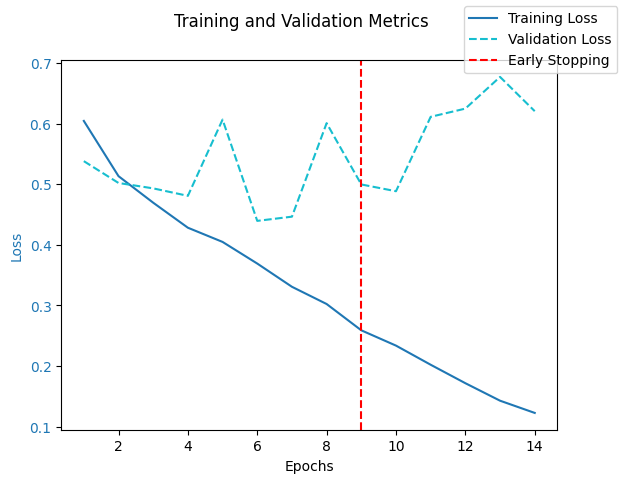


Training with seed 20
Early stopping at epoch 18.
Best Val F1: 0.8293.


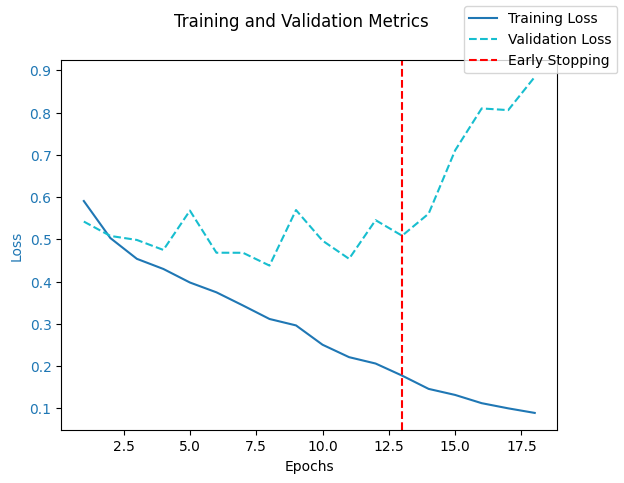


Training with seed 38
Early stopping at epoch 17.
Best Val F1: 0.8254.


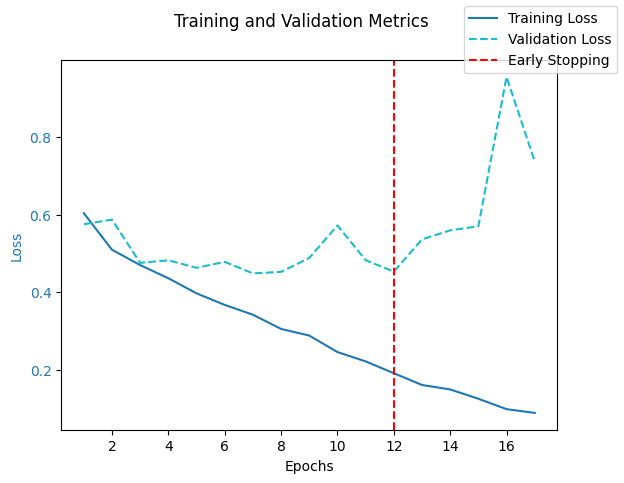


Training with seed 42
Early stopping at epoch 15.
Best Val F1: 0.8045.


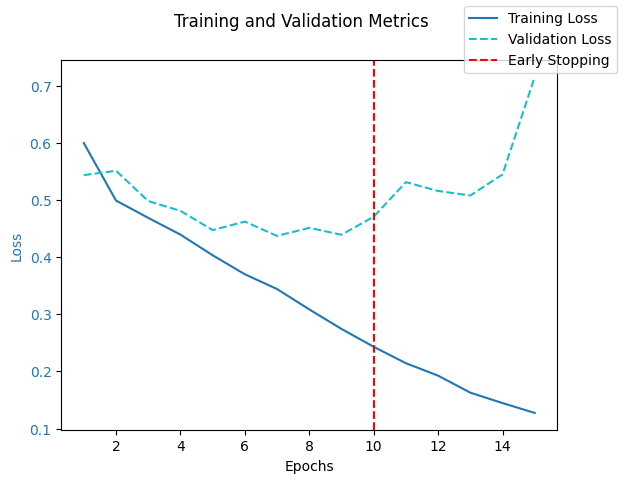


Training with seed 60
Early stopping at epoch 13.
Best Val F1: 0.8162.


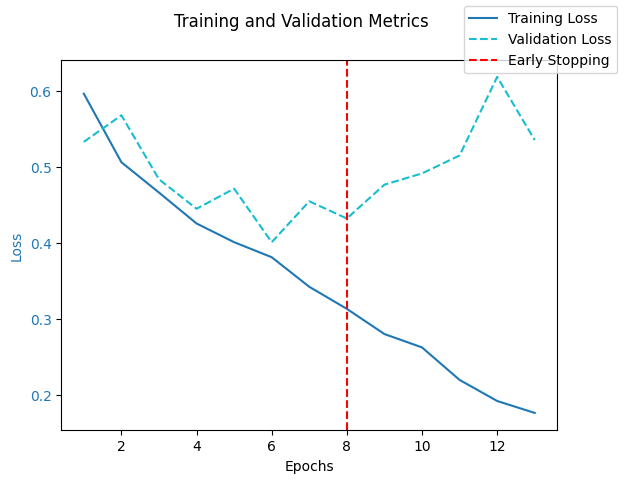

In [ ]:
main_training(x_train, y_train, x_val, y_val, input_size, hidden_size, num_layers, output_size, embedding_dim, models_baseline,learning_rate,num_epochs,batch_size)

In [ ]:
def evaluate_models(models, x_test, y_test, batch_size=128, device = device):
    accuracies, f1_scores = [], []
    for i, model in enumerate(models):
        test_accuracy, test_f1 = evaluate_bilstm_model(model, x_test, y_test, batch_size=128, device = device)
        accuracies.append(test_accuracy)
        f1_scores.append(test_f1)
        print(f"Model {i + 1}:")
        print(f"  Test Accuracy: {test_accuracy:.4f}")
        print(f"  Test F1 Score: {test_f1:.4f}\n")

    average_accuracy = np.mean(accuracies)
    average_f1 = np.mean(f1_scores)
    std_accuracy = np.std(accuracies)
    std_f1 = np.std(f1_scores)
    print(f"Average Accuracy: {average_accuracy:.4f}")
    print(f"Average F1 Score: {average_f1:.4f}\n")
    print(f"Standard Deviation Accuracy: {std_accuracy:.4f}")
    print(f"Standard Deviation F1 Score: {std_f1:.4f}")

In [ ]:
evaluate_models(models_baseline, x_test, y_test, batch_size=128, device=device)

Model 1:
  Test Accuracy: 0.7343
  Test F1 Score: 0.7305

Model 2:
  Test Accuracy: 0.7902
  Test F1 Score: 0.7784

Model 3:
  Test Accuracy: 0.7483
  Test F1 Score: 0.7416

Model 4:
  Test Accuracy: 0.7483
  Test F1 Score: 0.7421

Model 5:
  Test Accuracy: 0.7692
  Test F1 Score: 0.7646

Average Accuracy: 0.7580
Average F1 Score: 0.7514

Standard Deviation Accuracy: 0.0196
Standard Deviation F1 Score: 0.0175


We take the model with the best performances on the test set, which is the one with seed = 20, and store its errors in order to later perform the error analysis.

In [ ]:
baseline_error_df,score_baseline,target_baseline,predicted_baseline= collect_errors(models_baseline[1], x_test, y_test ,test_df_embedded, batch_size=128)

**MODEL-1**

We run the model-1 with same hyperparameters (besides the number of layers) and with the same 5 different seeds


Training with seed 5
Layer                                    Parameters     
lstm.weight_ih_l0                        12800          
lstm.weight_hh_l0                        4096           
lstm.bias_ih_l0                          128            
lstm.bias_hh_l0                          128            
lstm.weight_ih_l0_reverse                12800          
lstm.weight_hh_l0_reverse                4096           
lstm.bias_ih_l0_reverse                  128            
lstm.bias_hh_l0_reverse                  128            
lstm.weight_ih_l1                        8192           
lstm.weight_hh_l1                        4096           
lstm.bias_ih_l1                          128            
lstm.bias_hh_l1                          128            
lstm.weight_ih_l1_reverse                8192           
lstm.weight_hh_l1_reverse                4096           
lstm.bias_ih_l1_reverse                  128            
lstm.bias_hh_l1_reverse                  128            
fc.weight

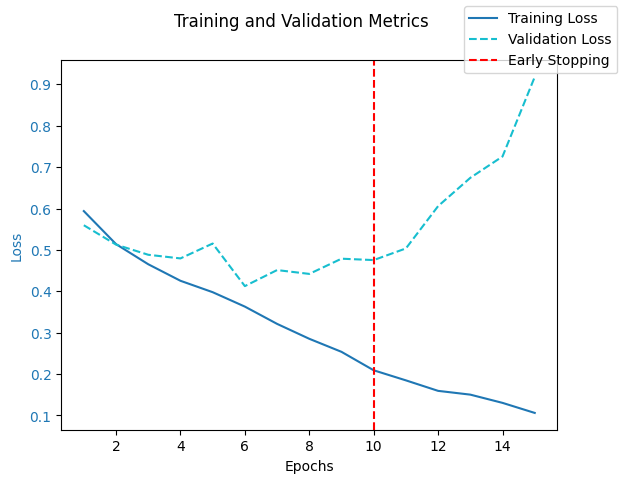


Training with seed 20
Early stopping at epoch 13.
Best Val F1: 0.7970.


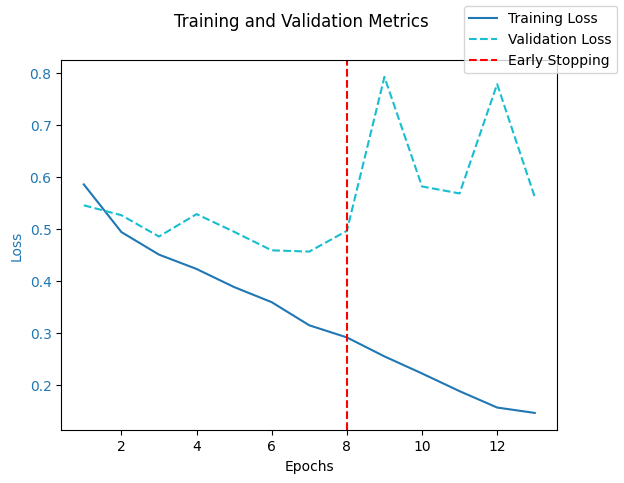


Training with seed 38
Early stopping at epoch 15.
Best Val F1: 0.8032.


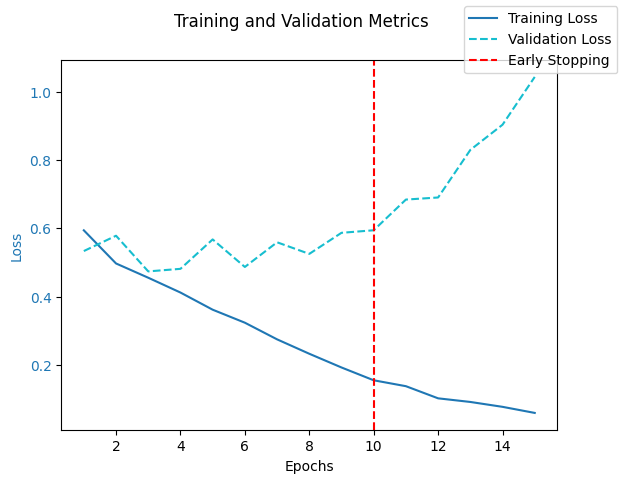


Training with seed 42
Early stopping at epoch 14.
Best Val F1: 0.8363.


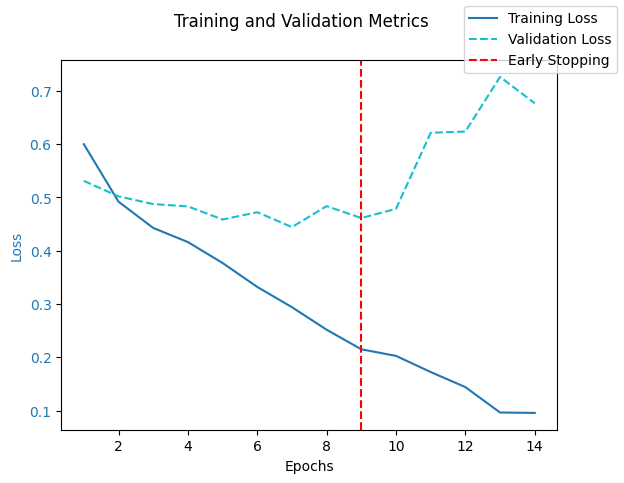


Training with seed 60
Early stopping at epoch 9.
Best Val F1: 0.7911.


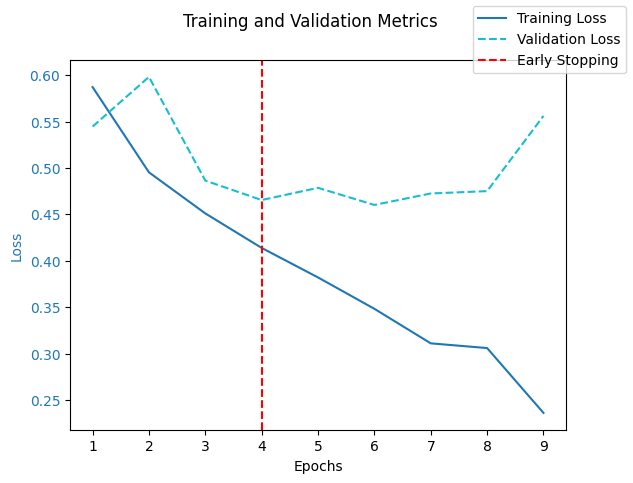

In [ ]:
#HYPERPARAMETER FOR THE MODEL_1
num_layers = 2
models_model1 = []
main_training(x_train, y_train, x_val, y_val, input_size, hidden_size, num_layers, output_size, embedding_dim,models_model1, learning_rate,num_epochs,batch_size)

In [ ]:
evaluate_models(models_model1, x_test, y_test, batch_size=128, device=device)

Model 1:
  Test Accuracy: 0.7587
  Test F1 Score: 0.7464

Model 2:
  Test Accuracy: 0.7483
  Test F1 Score: 0.7451

Model 3:
  Test Accuracy: 0.7727
  Test F1 Score: 0.7640

Model 4:
  Test Accuracy: 0.7867
  Test F1 Score: 0.7818

Model 5:
  Test Accuracy: 0.7692
  Test F1 Score: 0.7646

Average Accuracy: 0.7671
Average F1 Score: 0.7604

Standard Deviation Accuracy: 0.0130
Standard Deviation F1 Score: 0.0136


We take the model with the best performances on the test set, which is the one with seed = 42, and store its errors in order to later perform the error analysis.

In [ ]:
model1_error_df,score_model1,target_model1,predicted_model1 = collect_errors(models_model1[3], x_test, y_test,test_df_embedded, batch_size=128)

# [Task 6 - 1.0 points] Transformers

In this section, you will use a transformer model specifically trained for hate speech detection, namely [Twitter-roBERTa-base for Hate Speech Detection](https://huggingface.co/cardiffnlp/twitter-roberta-base-hate).




### Relevant Material
- Tutorial 3

### Instructions
1. **Load the Tokenizer and Model**

2. **Preprocess the Dataset**:
   You will need to preprocess your dataset to prepare it for input into the model. Tokenize your text data using the appropriate tokenizer and ensure it is formatted correctly.

   **Note**: You have to use the plain text of the dataset and not the version that you tokenized before, as you need to tokenize the cleaned text obtained after the initial cleaning process.

3. **Train the Model**:
   Use the `Trainer` to train the model on your training data.

4. **Evaluate the Model on the Test Set** using F1-macro.

In [ ]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 23.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 14.9 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [ ]:
from transformers import AutoModelForSequenceClassification
from transformers import TFAutoModelForSequenceClassification
from transformers import AutoTokenizer
import numpy as np
from scipy.special import softmax
import csv
import urllib.request
from datasets import Dataset
from transformers import TrainingArguments
from transformers import DataCollatorWithPadding
from transformers import Trainer
from sklearn.metrics import f1_score, accuracy_score

**1.** Load the Tokenizer and Model

In [ ]:
# to run only once
task='hate'
MODEL = f"cardiffnlp/twitter-roberta-base-{task}"
tokenizer = AutoTokenizer.from_pretrained(MODEL)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/700 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

In [ ]:
transformer_model = AutoModelForSequenceClassification.from_pretrained(MODEL)
transformer_model.save_pretrained(MODEL)

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

**2.** Preprocess the Dataset: You will need to preprocess your dataset to prepare it for input into the model. Tokenize your text data using the appropriate tokenizer and ensure it is formatted correctly.

In [ ]:
train_df = original_train_df.copy()
validation_df = original_validation_df.copy()
test_df = original_test_df.copy()

We decided to apply the same cleaning process as before

In [ ]:
# Download NLTK resources (only need to run this once)
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('wordnet')
nltk.download('stopwords')

# Function to clean tweets
def clean_tweet(tweet):
    # Remove emojis using a regex
    tweet = re.sub(r'[^\x00-\x7F]+', '', tweet)

    # Remove hashtags (e.g., #example)
    tweet = re.sub(r'#\w+', '', tweet)

    # Remove mentions (e.g., @user)
    tweet = re.sub(r'@\w+', '', tweet)

    # Remove URLs
    tweet = re.sub(r'http\S+|www\S+', '', tweet)

    # Remove special characters and symbols
    tweet = re.sub(r'[^a-zA-Z0-9\s]', '', tweet)

    # Remove specific quote characters (curly quotes, etc.)
    tweet = tweet.replace('“', '').replace('”', '').replace('‘', '').replace('’', '')

    # Convert to lowercase
    tweet = tweet.lower()

    return tweet

print(train_df['tweet'][0])
# Apply the cleaning function to the 'tweet' column
train_df['tweet'] = train_df['tweet'].apply(clean_tweet)
validation_df['tweet'] = validation_df['tweet'].apply(clean_tweet)
test_df['tweet'] = test_df['tweet'].apply(clean_tweet)
print(train_df['tweet'][0])

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Writing a uni essay in my local pub with a coffee. Random old man keeps asking me drunk questions when I'm trying to concentrate &amp; ends with "good luck, but you'll just end up getting married and not use it anyway". #EverydaySexism is alive and well 🙃
writing a uni essay in my local pub with a coffee random old man keeps asking me drunk questions when im trying to concentrate amp ends with good luck but youll just end up getting married and not use it anyway  is alive and well 


In [ ]:
def preprocess_text(texts):
    return tokenizer(texts['tweet'], truncation=True)

train_data = Dataset.from_pandas(train_df)
validation_data = Dataset.from_pandas(validation_df)
test_data = Dataset.from_pandas(test_df)

train_data = train_data.map(preprocess_text, batched=True)
validation_data = validation_data.map(preprocess_text, batched=True)
test_data = test_data.map(preprocess_text, batched=True)
train_data

Map:   0%|          | 0/2870 [00:00<?, ? examples/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Map:   0%|          | 0/158 [00:00<?, ? examples/s]

Map:   0%|          | 0/286 [00:00<?, ? examples/s]

Dataset({
    features: ['id_EXIST', 'lang', 'tweet', 'hard_label_task1', '__index_level_0__', 'input_ids', 'attention_mask'],
    num_rows: 2870
})

In [ ]:
train_data = train_data.rename_column('hard_label_task1', 'label')
validation_data = validation_data.rename_column('hard_label_task1', 'label')
test_data = test_data.rename_column('hard_label_task1', 'label')

**3.** Train the Model: Use the Trainer to train the model on your training data.

In [ ]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [ ]:
def compute_metrics(output_info):
    predictions, labels = output_info
    predictions = np.argmax(predictions, axis=-1)

    f1 = f1_score(y_pred=predictions, y_true=labels, average='macro')
    acc = accuracy_score(y_pred=predictions, y_true=labels)
    return {'f1': f1, 'acc': acc}

In [ ]:
training_args = TrainingArguments(
    output_dir="test_dir",
    learning_rate= 2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=8,
    num_train_epochs=2,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    report_to='none'
)

In [ ]:
trainer = Trainer(
    model=transformer_model,
    args=training_args,
    train_dataset=train_data,
    eval_dataset=validation_data,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

In [ ]:
#train with 2 epochs
trainer.train()

Epoch,Training Loss,Validation Loss,F1,Acc
1,No log,0.322838,0.867272,0.873418
2,No log,0.318658,0.881815,0.886076


TrainOutput(global_step=360, training_loss=0.326921017964681, metrics={'train_runtime': 141.2294, 'train_samples_per_second': 40.643, 'train_steps_per_second': 2.549, 'total_flos': 176954518060320.0, 'train_loss': 0.326921017964681, 'epoch': 2.0})

4. Evaluate the Model on the Test Set using F1-macro.

In [ ]:
test_prediction_info = trainer.predict(test_data)
test_predictions, test_labels = test_prediction_info.predictions, test_prediction_info.label_ids

In [ ]:
test_metrics = compute_metrics([test_predictions, test_labels])
print(test_metrics)

{'f1': 0.8664799253034547, 'acc': 0.8671328671328671}


In [ ]:
def collect_errors_transf(trainer, test_data, test_df, batch_size=128):
    texts = test_df['tweet']
    test_prediction_info = trainer.predict(test_data)
    test_predictions, test_labels = test_prediction_info.predictions, test_prediction_info.label_ids
    test_predictions = np.argmax(test_predictions, axis=-1)

    error_texts = []
    labels = []
    error_label = []

    for i, (pred, label) in enumerate(zip(test_predictions, test_labels)):
        if pred != label:
            error_texts.append(texts.iloc[i])
            labels.append(label)
            error_label.append(pred)

    errors_df = pd.DataFrame({
        'tweet': error_texts,
        'true_label': labels,
        'predicted_label': error_label

    })
    return errors_df

In [ ]:
transformer_error_df = collect_errors_transf(trainer, test_data, test_df_embedded)

# [Task 7 - 0.5 points] Error Analysis

### Instructions

After evaluating the model, perform a brief error analysis:

 - Review the results and identify common errors.

 - Summarize your findings regarding the errors and their impact on performance (e.g. but not limited to Out-of-Vocabulary (OOV) words, data imbalance, and performance differences between the custom model and the transformer...)
 - Suggest possible solutions to address the identified errors.



In [ ]:
train_df = original_train_df.copy()
validation_df = original_validation_df.copy()
test_df = original_test_df.copy()

## **DATA DISTRIBUTION**
We start analysing the label distribution among the available datasets


Train dataset:
Label 0: 1733 (60.38%)
Label 1: 1137 (39.62%)

Validation dataset:
Label 0: 90 (56.96%)
Label 1: 68 (43.04%)

Test dataset:
Label 0: 160 (55.94%)
Label 1: 126 (44.06%)


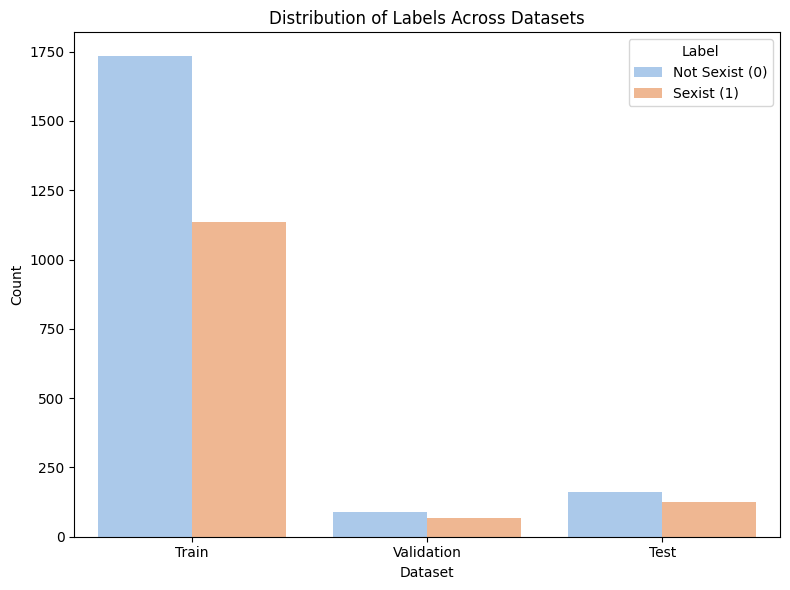

In [ ]:
train_df['Dataset'] = 'Train'
validation_df['Dataset'] = 'Validation'
test_df['Dataset'] = 'Test'

def print_label_distribution(df, dataset_name):
    counts = df['hard_label_task1'].value_counts()
    total = counts.sum()
    print(f'\n{dataset_name} dataset:')
    for label, count in counts.items():
        percentage = (count / total) * 100
        print(f"Label {label}: {count} ({percentage:.2f}%)")

print_label_distribution(train_df, "Train")
print_label_distribution(validation_df, "Validation")
print_label_distribution(test_df, "Test")

combined_df = pd.concat([train_df, validation_df, test_df])

plt.figure(figsize=(8, 6))
sns.countplot(
    data=combined_df,
    x='Dataset',
    hue='hard_label_task1',
    palette='pastel'
)

plt.title('Distribution of Labels Across Datasets')
plt.xlabel('Dataset')
plt.ylabel('Count')
plt.legend(title='Label', labels=['Not Sexist (0)', 'Sexist (1)'])
plt.tight_layout()
plt.show()

We plotted the distribution of the TRUE LABELS across the errors of each model in order to discover relationships between them and the data distribution in the datasets


Baseline errors:
Label 1.0: 46 (76.67%)
Label 0.0: 14 (23.33%)

Model 1 errors:
Label 1.0: 35 (57.38%)
Label 0.0: 26 (42.62%)

Transformer errors:
Label 0.0: 26 (68.42%)
Label 1.0: 12 (31.58%)


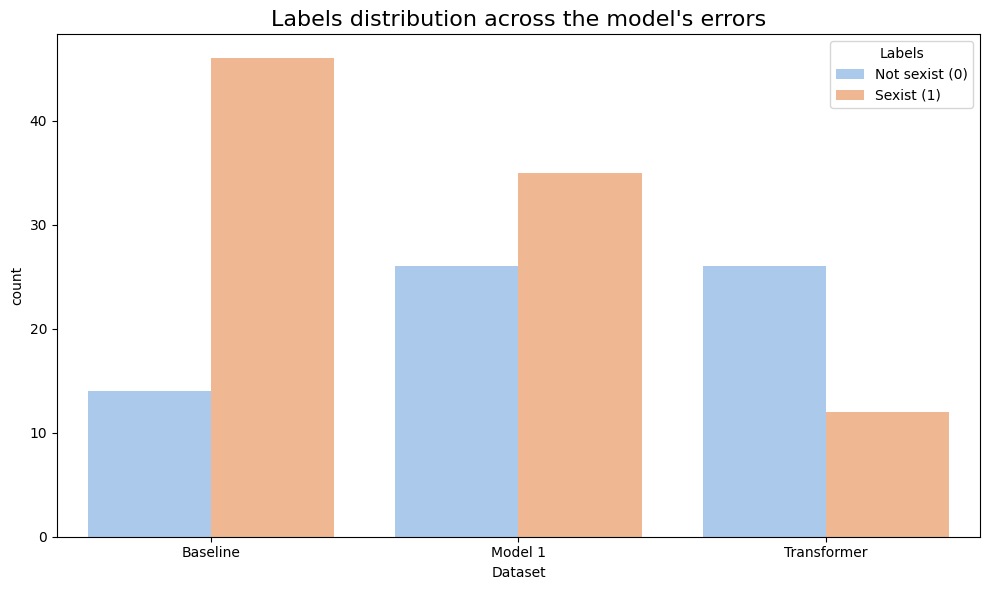

In [ ]:
true_labels_baseline = baseline_error_df['true_label']
true_labels_model1 = model1_error_df['true_label']
true_labels_transformer = transformer_error_df['true_label']

combined_df = pd.DataFrame({
    'Dataset': ['Baseline'] * len(true_labels_baseline) +
               ['Model 1'] * len(true_labels_model1) +
               ['Transformer'] * len(true_labels_transformer),
    'hard_label_task1': true_labels_baseline.tolist() +
                        true_labels_model1.tolist() +
                        true_labels_transformer.tolist()
})

def print_label_distribution_for_models(df):
    datasets = df['Dataset'].unique()
    for dataset in datasets:
        subset = df[df['Dataset'] == dataset]
        counts = subset['hard_label_task1'].value_counts()
        total = counts.sum()
        print(f'\n{dataset} errors:')
        for label, count in counts.items():
            percentage = (count / total) * 100
            print(f"Label {label}: {count} ({percentage:.2f}%)")

print_label_distribution_for_models(combined_df)

plt.figure(figsize=(10, 6))
sns.countplot(
    data=combined_df,
    x='Dataset',
    hue='hard_label_task1',
    palette='pastel'
)

plt.title("Labels distribution across the model's errors", fontsize=16)
plt.legend(title='Labels', labels=['Not sexist (0)', 'Sexist (1)'], fontsize=10)
plt.tight_layout()
plt.show()

## **TWEET LENGTH**
We have compared the lenght of the tweets in the test set and the lenght of the misclassified tweets of the transformer model.

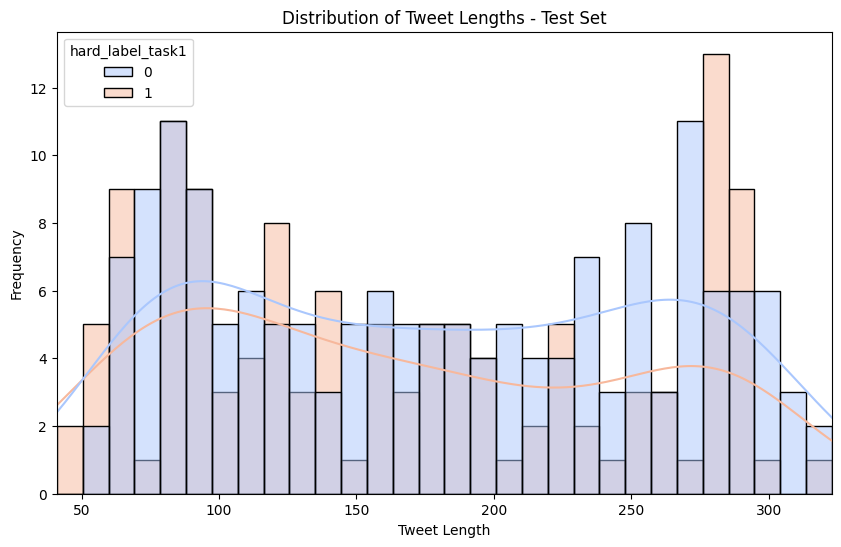

In [ ]:
def plot_distr_tweet_len(data_list_or, labels):
    data_list = []
    for data_or in data_list_or:
        data = data_or.copy()
        data['tweet_length'] = data['tweet'].apply(len)
        data_list.append(data)

    all_lengths = pd.concat([data['tweet_length'] for data in data_list])
    x_min, x_max = all_lengths.min(), all_lengths.max()

    for i, data in enumerate(data_list):
        plt.figure(figsize=(10, 6))
        sns.histplot(data, x='tweet_length', hue='hard_label_task1', bins=30, kde=True, palette='coolwarm')
        plt.title(f'Distribution of Tweet Lengths - {labels[i]}')
        plt.xlabel('Tweet Length')
        plt.ylabel('Frequency')
        plt.xlim(x_min, x_max)
        plt.show()

plot_distr_tweet_len([test_df], labels=['Test Set'])

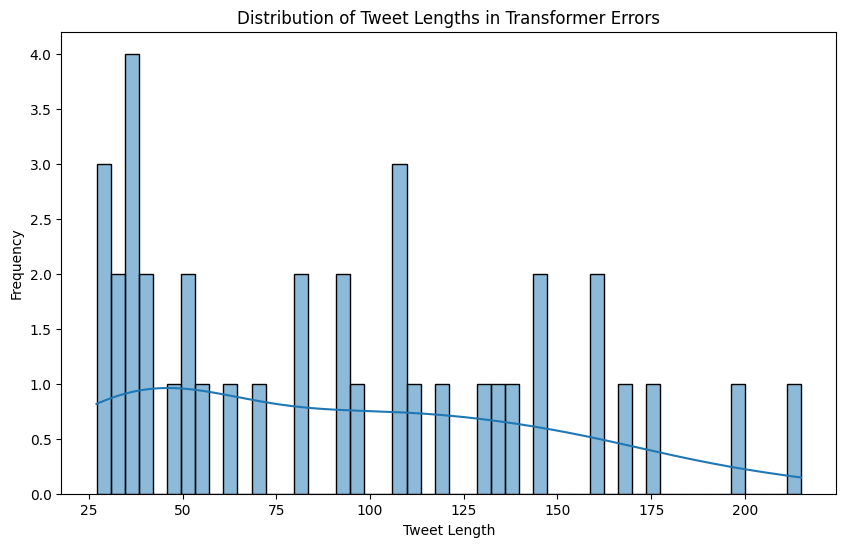

In [ ]:
transformer_error_df['tweet_length'] = transformer_error_df['tweet'].apply(len)

plt.figure(figsize=(10, 6))
sns.histplot(transformer_error_df['tweet_length'], bins=50, kde=True,)
plt.title('Distribution of Tweet Lengths in Transformer Errors')
plt.xlabel('Tweet Length')
plt.ylabel('Frequency')
plt.show()

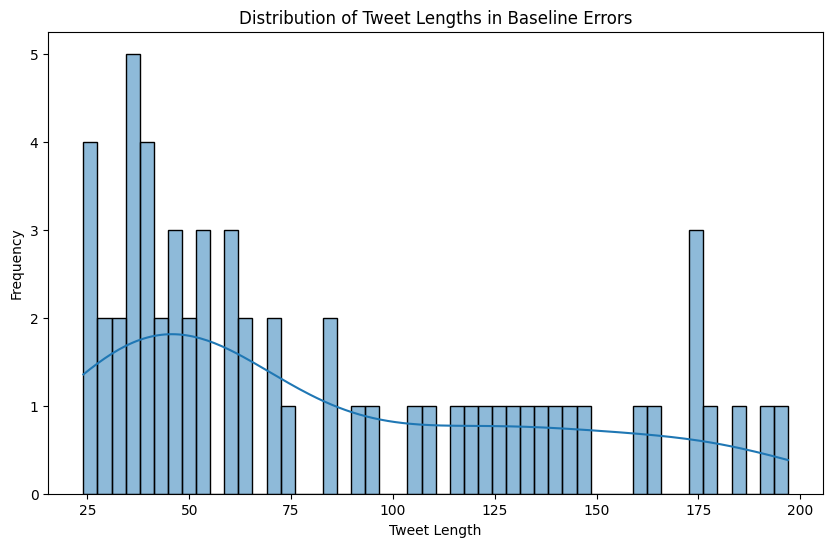

In [ ]:
baseline_error_df['tweet_length'] = baseline_error_df['tweet'].apply(len)

plt.figure(figsize=(10, 6))
sns.histplot(baseline_error_df['tweet_length'], bins=50, kde=True,)
plt.title('Distribution of Tweet Lengths in Baseline Errors')
plt.xlabel('Tweet Length')
plt.ylabel('Frequency')
plt.show()

## **CONFUSION MATRIX AND PRECISION-RECALL CURVE**
We show the confusion matrix and the precision-recal curve for all the three models.

In [ ]:
from sklearn.metrics import confusion_matrix, precision_recall_curve, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

def plot_evaluation_metrics(all_predictions, all_targets, model_name, predictions, transformer):
    """
    Plots the confusion matrix and precision-recall curve for a given model.

    Args:
        all_predictions: Array of predicted probabilities or scores.
        all_targets: Array of true labels.
        model_name: The name of the model (e.g., "Baseline", "Model 1", "Transformer").
        predictions: Array of predicted labels (0 or 1).
        transformer: Boolean indicating if the model is a transformer (handles multi-class probabilities).

    """
    # Confusion Matrix
    cm = confusion_matrix(all_targets, predictions)
    plt.figure(figsize=(5, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

    # Precision-Recall Curve
    if transformer:
        precision, recall, thresholds = precision_recall_curve(all_targets, all_predictions[:, 1])
    else:
        precision, recall, thresholds = precision_recall_curve(all_targets, all_predictions)

    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, label='Precision-Recall Curve')
    plt.fill_between(recall, precision, alpha=0.4, color='skyblue')

    for i, threshold in enumerate(thresholds):
        if i % max(1, len(thresholds) // 10) == 0:
            plt.annotate(f'{threshold:.2f}',
                         (recall[i], precision[i]),
                         textcoords="offset points", xytext=(-10, 10), ha='center', fontsize=8,
                         color='red', arrowprops=dict(arrowstyle='->', color='red', lw=0.5))

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve - {model_name}')
    plt.legend(loc='lower left')
    plt.show()

    print('Classification Report:')
    print(classification_report(all_targets, predictions))


In [ ]:
predictions_trans = np.argmax(test_predictions, axis=-1)

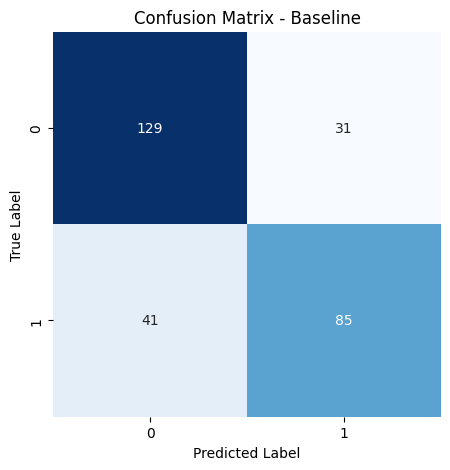

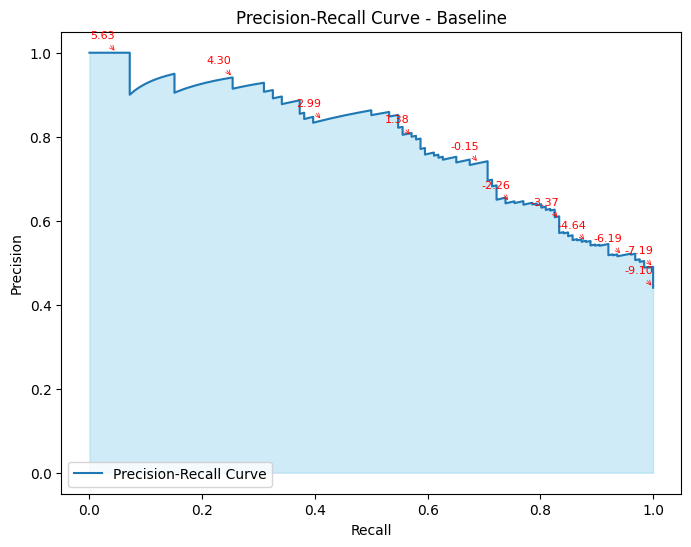

Classification Report:
              precision    recall  f1-score   support

         0.0       0.76      0.81      0.78       160
         1.0       0.73      0.67      0.70       126

    accuracy                           0.75       286
   macro avg       0.75      0.74      0.74       286
weighted avg       0.75      0.75      0.75       286



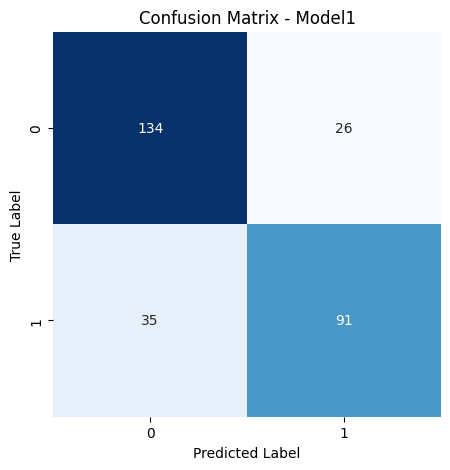

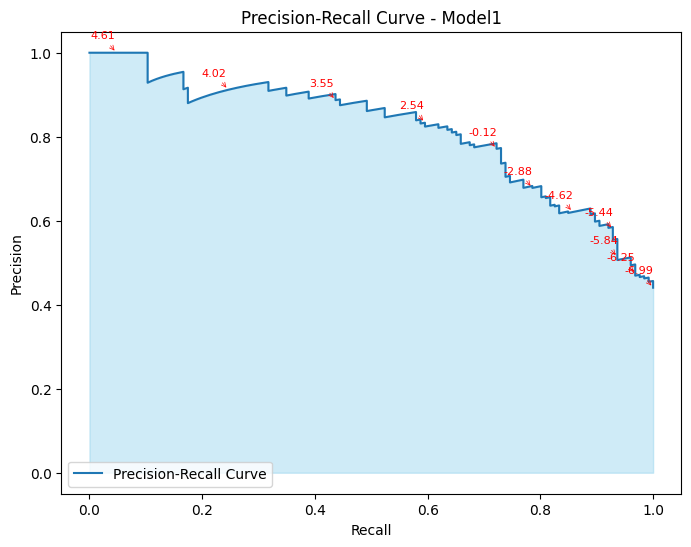

Classification Report:
              precision    recall  f1-score   support

         0.0       0.79      0.84      0.81       160
         1.0       0.78      0.72      0.75       126

    accuracy                           0.79       286
   macro avg       0.79      0.78      0.78       286
weighted avg       0.79      0.79      0.79       286



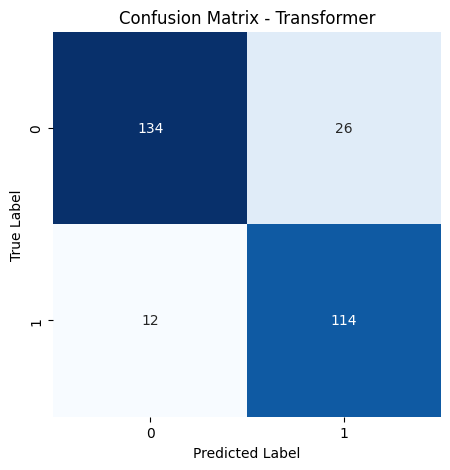

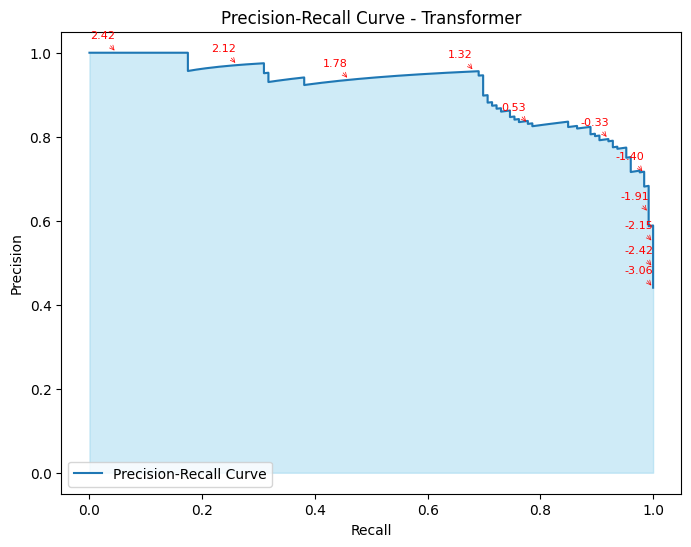

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.84      0.88       160
           1       0.81      0.90      0.86       126

    accuracy                           0.87       286
   macro avg       0.87      0.87      0.87       286
weighted avg       0.87      0.87      0.87       286



In [ ]:
plot_evaluation_metrics(score_baseline,target_baseline,'Baseline',predicted_baseline,transformer=False)
plot_evaluation_metrics(score_model1,target_model1,'Model1',predicted_model1,transformer=False)
plot_evaluation_metrics(test_predictions, test_labels,'Transformer',predictions_trans,transformer=True)

## **MOST FREQUENT WORDS IN THE WRONG PREDICTIONS**

In [ ]:
import pandas as pd
from collections import Counter
import string
import matplotlib.pyplot as plt

def get_top_words_by_label(df, text_column, label_column, top_n=30, stop_words=None):
    if stop_words is None:
        stop_words = []

    def preprocess_text(text):
        return text.translate(str.maketrans('', '', string.punctuation)).lower()

    df[text_column] = df[text_column].apply(preprocess_text)

    label_word_counts = {}
    for label in df[label_column].unique():
        texts = df[df[label_column] == label][text_column]
        all_words = " ".join(texts).split()
        filtered_words = [word for word in all_words if word not in stop_words]
        word_counts = Counter(filtered_words)
        label_word_counts[label] = word_counts.most_common(top_n)

    return label_word_counts

def plot_top_words(label_word_counts):
    for label, word_counts in label_word_counts.items():
        words, counts = zip(*word_counts)

        plt.figure(figsize=(30, 5))
        plt.bar(words, counts, color='skyblue')
        plt.title(f"Most frequent words when we incorrectly predict the label {label}")
        plt.xlabel("Words")
        plt.ylabel("Frequence")
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

Transformer's most frequent words in wrong predictions

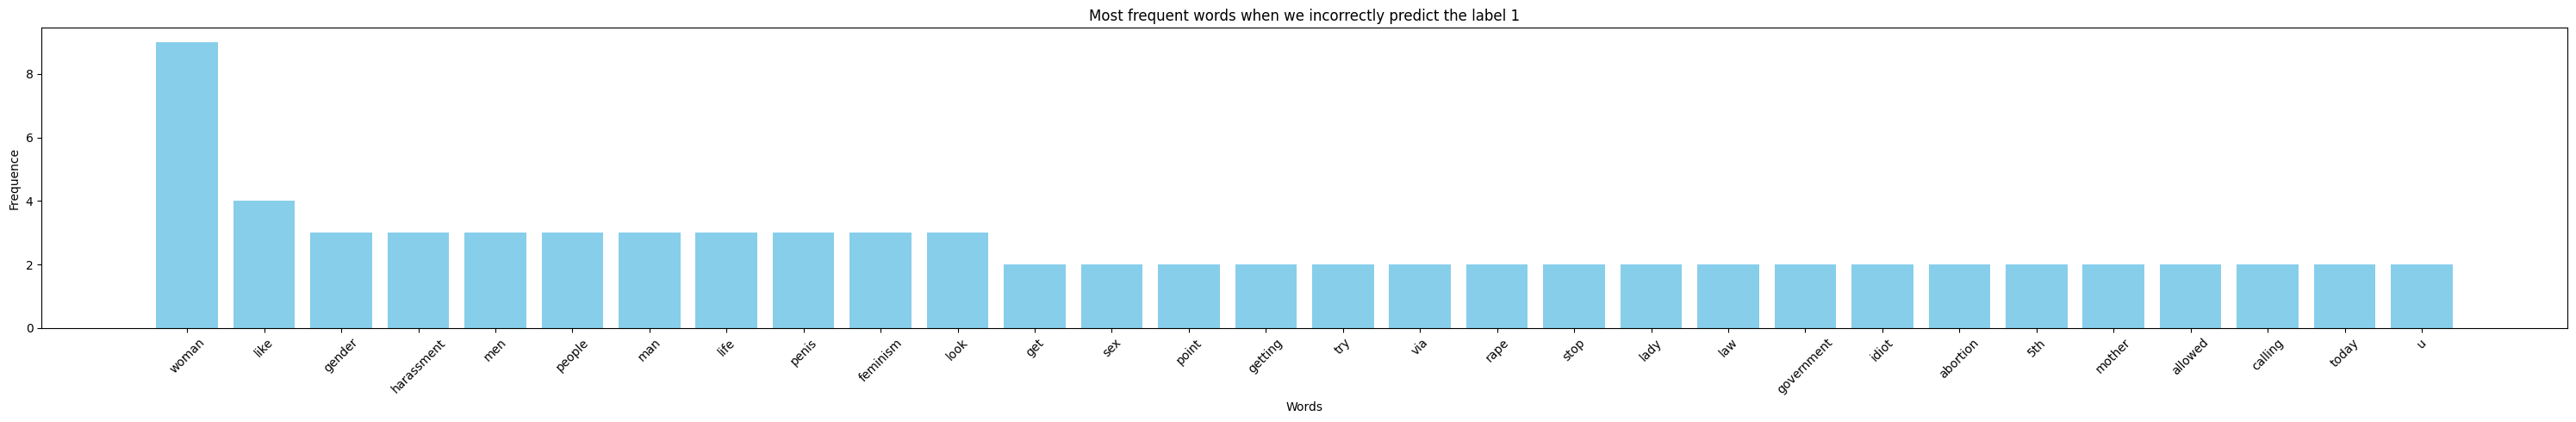

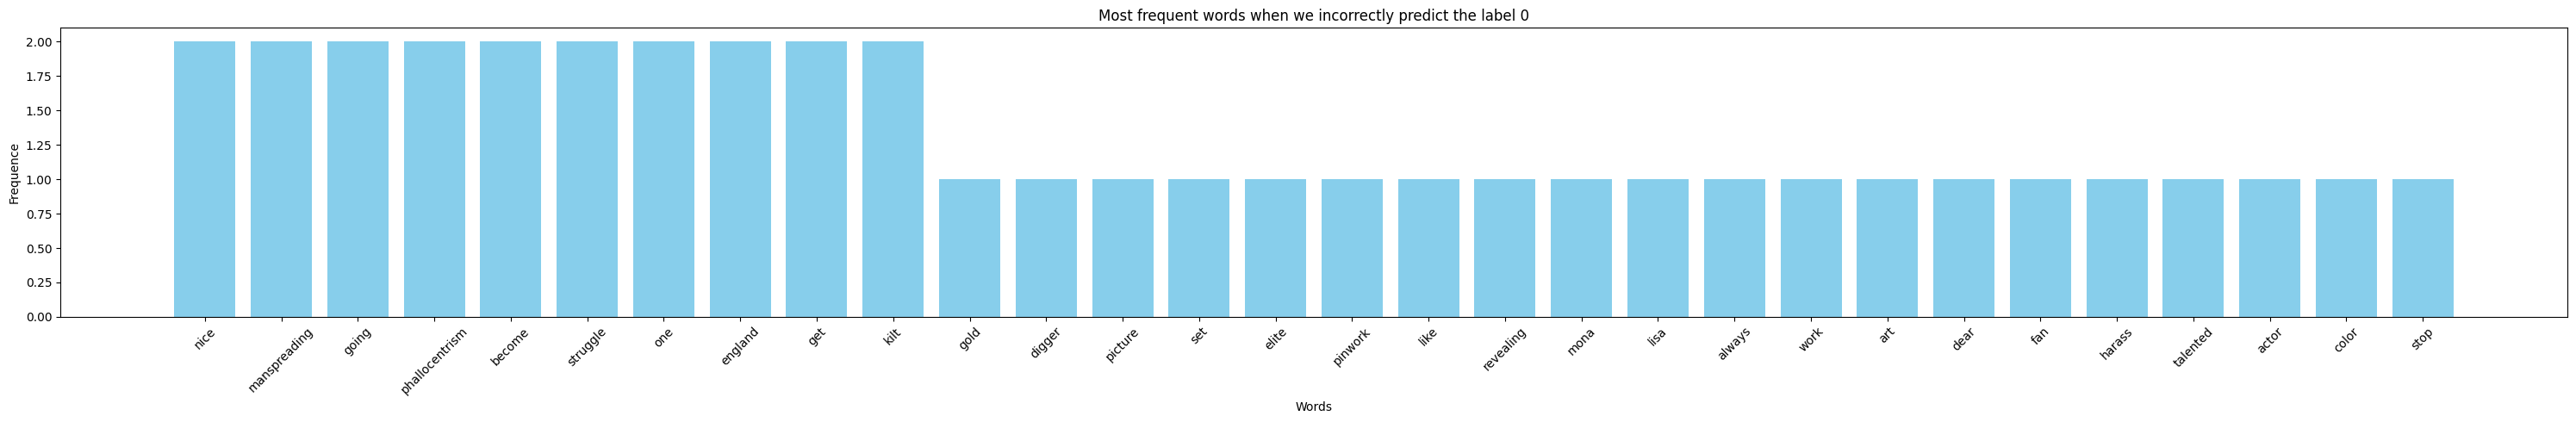

In [ ]:
# here we defined some stop words
stop_words = ["http", "cant", "let", "dont", "thats", "doesnt","yall"]

top_words = get_top_words_by_label(transformer_error_df, text_column="tweet", label_column="predicted_label", top_n=30, stop_words=stop_words)
plot_top_words(top_words)

Baseline's most frequent words in wrong predictions

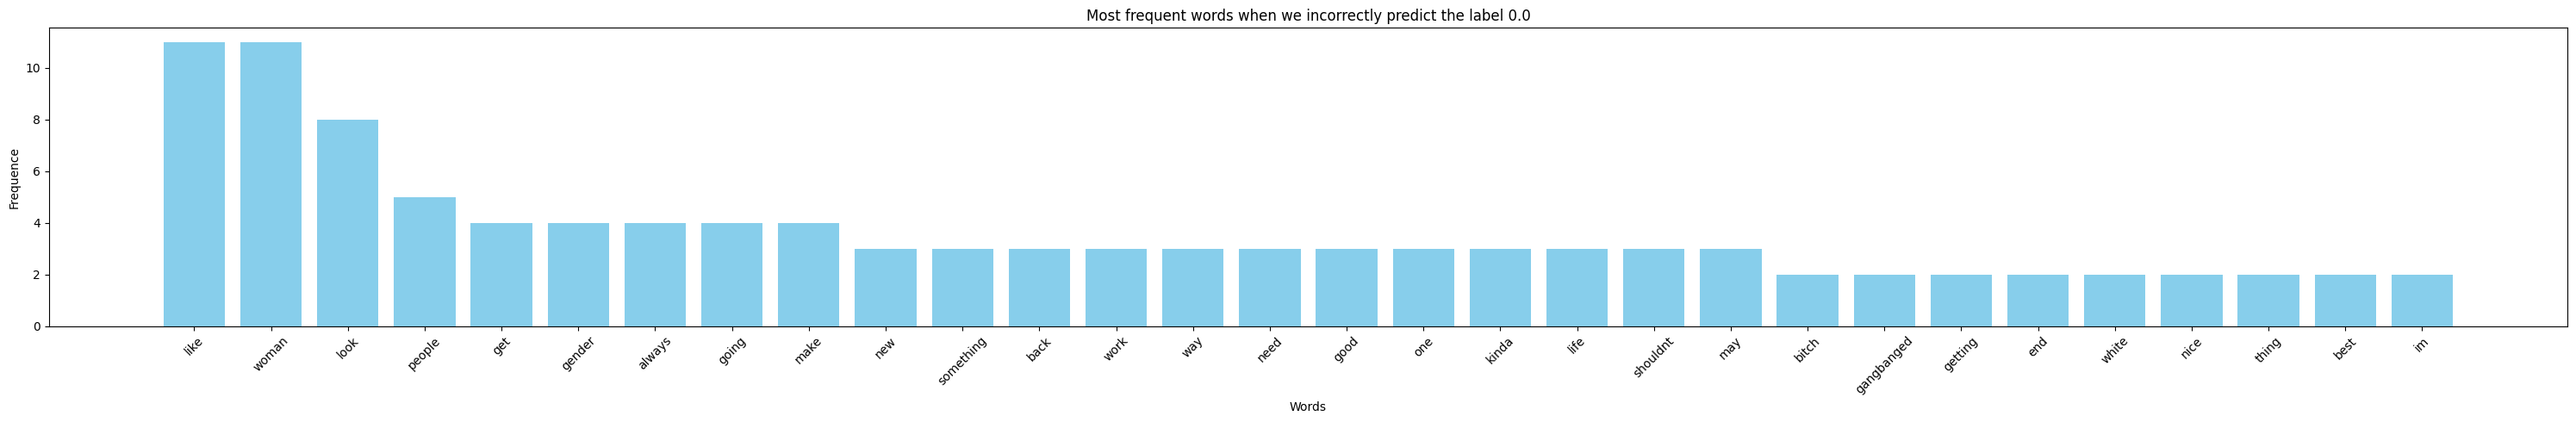

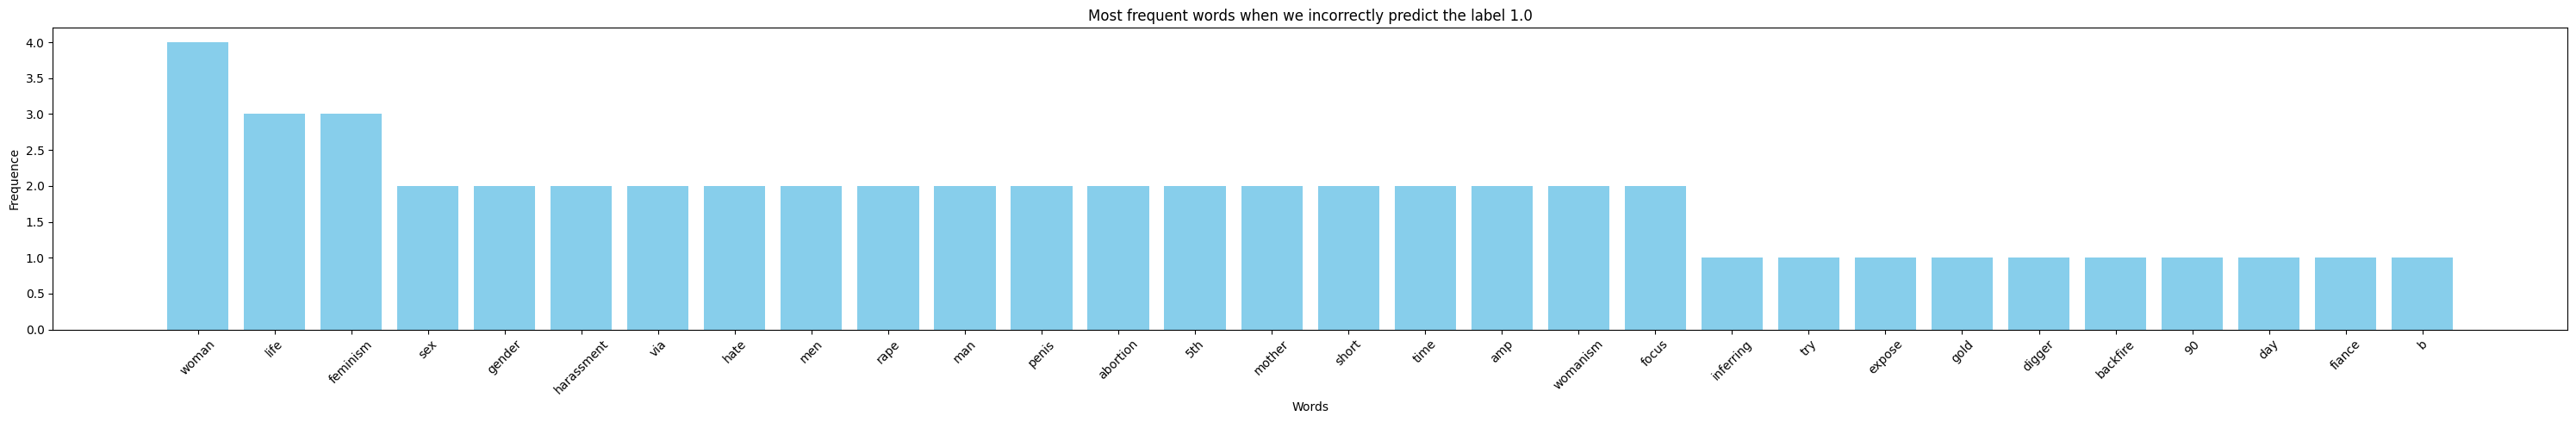

In [ ]:
top_words = get_top_words_by_label(baseline_error_df, text_column="tweet", label_column="predicted_label", top_n=30, stop_words=stop_words)
plot_top_words(top_words)

## **MISCLASSIFIED TWEETS**
We print each misclassified tweets of the baseline model highligthing the OOV words.
It can be observed that several OOVs are words that are misspelled, either due to grammatical errors or because they are slang words that differ from the correct version, which might be present in GloVe.

In [ ]:
def has_oov_tokens(tweet, vocab):
    """Checks if a tweet contains any OOV tokens."""
    words = tweet.split()
    for word in words:
        if word not in vocab and word != "<PAD>":
            return True
    return False

In [ ]:
def highlight_oov_tokens(tweet, vocab):
    """Highlights OOV tokens in a tweet using ANSI escape codes."""
    words = tweet.split()
    oov_tokens = []
    highlighted_words = []
    for word in words:
        if word not in vocab and word != "<PAD>":
            highlighted_words.append(f"\033[91m{word}\033[0m")
            oov_tokens.append(word)
        else:
            highlighted_words.append(word)
    return " ".join(highlighted_words), oov_tokens


all_oov_tokens = []

for index, row in baseline_error_df.iterrows():
    true_label = row['true_label']
    predicted_label = row['predicted_label']
    tweet = row['tweet']

    highlighted_tweet, oov_tokens = highlight_oov_tokens(tweet, vocab)
    all_oov_tokens.extend(oov_tokens)

    print("True Label:", "🔴" if true_label == 1 else "🟢", end=" ")
    print("Predicted Label:", "🔴" if predicted_label == 1 else "🟢", end=" ")
    print(highlighted_tweet)

print("\nAll OOV Tokens:")
print(", ".join(set(all_oov_tokens)))


True Label: 🔴 Predicted Label: 🟢 like outfit except dress frigid bitch try look constipated new
True Label: 🔴 Predicted Label: 🟢 suika get gangbanged death
True Label: 🟢 Predicted Label: 🔴 mean wouldnt fun get gangbanged together
True Label: 🔴 Predicted Label: 🟢 maybe something involving getting gangbanged
True Label: 🟢 Predicted Label: 🔴 sex gender harassment inferring
True Label: 🔴 Predicted Label: 🟢 kabul islamic emirate afghanistan announced end coeducation country citing gender harassmentfemale student attend university monday wednesday saturday tuesday thursday sunday fixed male
True Label: 🔴 Predicted Label: 🟢 violent antifeminism farright movement see principally vessel breeding new white generation express fixation areturn traditional gender rolesworth every minute read take 5 min sun
True Label: 🟢 Predicted Label: 🔴 reach point blonks audacity talk yoongis rap yall see stan yall ok girl cant write cant deliver cant come close btss lyricism tf yall getting brave fashion deal
T

## **OOV DISTRIBUTION**
We analyse the distribution of OOV words in misclassified tweets. The presence of OOVs might be significant for some incorrectly predicted sentences, but overall, it does not seem to be the only reason, nor the main one, leading the model to make several incorrect predictions.

In [ ]:
import matplotlib.pyplot as plt
from collections import Counter

def has_oov_tokens(tweet, vocab):
    """Checks if a tweet contains any OOV tokens and counts them."""
    words = tweet.split()
    oov_count = 0

    for word in words:
        if word not in vocab and word != "<PAD>":
            oov_count += 1

    has_oov = oov_count > 0
    return has_oov, oov_count

# Calculate percentage of errors with OOV tokens and plot distribution
def analyze_oov_distribution(model_error_df, vocab):
    errors_with_oov = 0
    oov_counts = []

    for index, row in model_error_df.iterrows():
        tweet = row['tweet']
        has_oov, oov_count = has_oov_tokens(tweet, vocab)
        if has_oov:
            errors_with_oov += 1
        oov_counts.append(oov_count)

    percentage_with_oov = (errors_with_oov / len(model_error_df)) * 100
    print(f"Percentage of sentences with OOV tokens: {percentage_with_oov:.2f}%")

    # Calculate the percentage of sentences for each OOV count
    oov_count_distribution = Counter(oov_counts)
    total_sentences = len(model_error_df)

    print("\nPercentage of sentences for each number of OOV tokens:")
    for oov_count, freq in sorted(oov_count_distribution.items()):
        percentage = (freq / total_sentences) * 100
        print(f"{oov_count} OOV token(s): {percentage:.2f}%")

    # Plot distribution of OOV tokens
    plt.hist(oov_counts, bins=range(0, max(oov_counts) + 2), edgecolor='black')
    plt.title("Distribution of OOV Tokens in Tweets")
    plt.xlabel("Number of OOV Tokens")
    plt.ylabel("Frequency")
    plt.show()



In [ ]:
correctly_classified_tweets = []
for row, predicted_label in zip(test_df_embedded.itertuples(), predicted_baseline):
    if row.hard_label_task1 == predicted_label:
        correctly_classified_tweets.append({
            'tweet': row.tweet,
            'original_label': row.hard_label_task1,
            'predicted_label': predicted_label
        })

correctly_classified_df = pd.DataFrame(correctly_classified_tweets)

OOV over the test set

Percentage of sentences with OOV tokens: 80.77%

Percentage of sentences for each number of OOV tokens:
0 OOV token(s): 19.23%
1 OOV token(s): 26.22%
2 OOV token(s): 14.34%
3 OOV token(s): 12.59%
4 OOV token(s): 9.09%
5 OOV token(s): 8.39%
6 OOV token(s): 3.85%
7 OOV token(s): 1.40%
8 OOV token(s): 2.10%
9 OOV token(s): 1.75%
11 OOV token(s): 1.05%


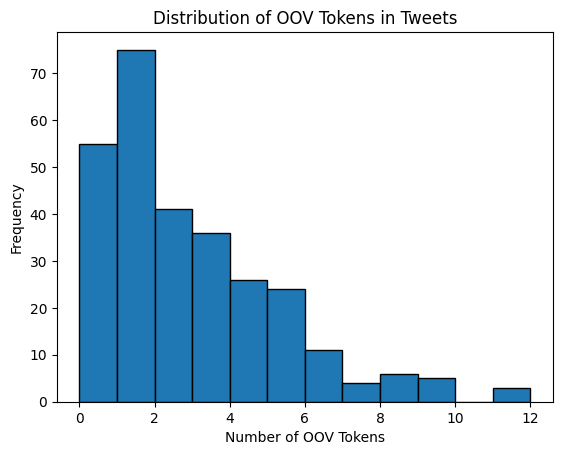

In [ ]:
analyze_oov_distribution(test_df, vocab)

OOV over the wrong predictions (baseline_error_df)

Percentage of sentences with OOV tokens: 77.78%

Percentage of sentences for each number of OOV tokens:
0 OOV token(s): 22.22%
1 OOV token(s): 27.78%
2 OOV token(s): 15.28%
3 OOV token(s): 13.89%
4 OOV token(s): 6.94%
5 OOV token(s): 5.56%
6 OOV token(s): 5.56%
7 OOV token(s): 1.39%
11 OOV token(s): 1.39%


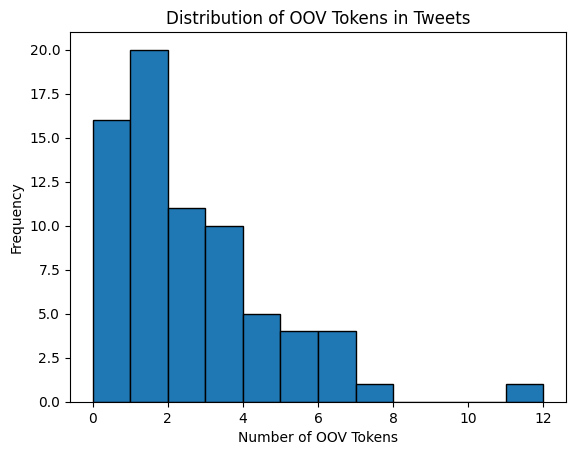

In [ ]:
analyze_oov_distribution(baseline_error_df, vocab)

OOV over the correct predicitons

Percentage of sentences with OOV tokens: 81.78%

Percentage of sentences for each number of OOV tokens:
0 OOV token(s): 18.22%
1 OOV token(s): 25.70%
2 OOV token(s): 14.02%
3 OOV token(s): 12.15%
4 OOV token(s): 9.81%
5 OOV token(s): 9.35%
6 OOV token(s): 3.27%
7 OOV token(s): 1.40%
8 OOV token(s): 2.80%
9 OOV token(s): 2.34%
11 OOV token(s): 0.93%


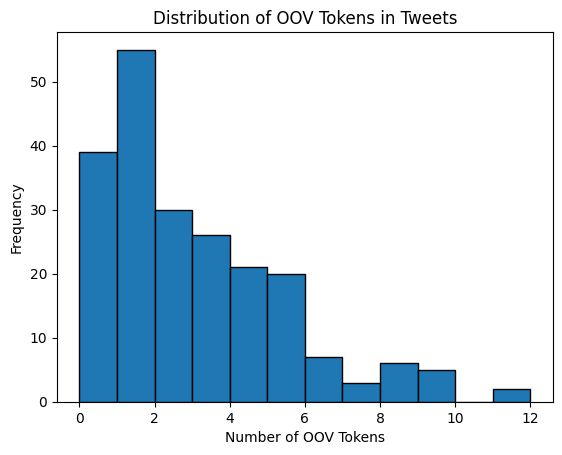

In [ ]:
analyze_oov_distribution(correctly_classified_df, vocab)

## **EMBEDDING SIZE INCREASED**

In [ ]:
embedding_dim = 200
glove_filepath = os.path.join(extract_path, f'glove.6B.{embedding_dim}d.txt')
glove_embeddings = load_glove_embeddings(glove_filepath, embedding_dim)
print("Loaded GloVe embeddings with dimension:", embedding_dim)

Loaded GloVe embeddings with dimension: 200


In [ ]:
train_df = original_train_df.copy()
validation_df = original_validation_df.copy()
test_df = original_test_df.copy()

In [ ]:
train_df['tweet'] = train_df['tweet'].apply(clean_tweet)
validation_df['tweet'] = validation_df['tweet'].apply(clean_tweet)
test_df['tweet'] = test_df['tweet'].apply(clean_tweet)

In [ ]:
train_df['padded_tweet'] = pad_tweets(train_df, 'tweet')
validation_df['padded_tweet'] = pad_tweets(validation_df, 'tweet')
test_df['padded_tweet'] = pad_tweets(test_df, 'tweet')
print('firsr padded tweet:')
print(train_df['padded_tweet'][0])
vocab, word_embeddings = build_vocab_and_embeddings_char(train_df, glove_embeddings, embedding_dim)
unk_token = '[UNK]'
vocab[unk_token] = len(vocab)
unk_embedding = np.mean(word_embeddings, axis=0)
word_embeddings = np.vstack([word_embeddings, unk_embedding])

max len: =36
max len: =32
max len: =33
firsr padded tweet:
['writing', 'uni', 'essay', 'local', 'pub', 'coffee', 'random', 'old', 'man', 'keep', 'asking', 'drunk', 'question', 'im', 'trying', 'concentrate', 'amp', 'end', 'good', 'luck', 'youll', 'end', 'getting', 'married', 'use', 'anyway', 'alive', 'well', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>']


In [ ]:
train_df_embedded = embed_tweet(train_df, vocab, word_embeddings)
validation_df_embedded = embed_tweet(validation_df, vocab, word_embeddings)
test_df_embedded = embed_tweet(test_df, vocab, word_embeddings)
print(len(train_df_embedded['padded_tweet'][0][0]))

200


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
x_train = torch.tensor(train_df_embedded['padded_tweet'], dtype=torch.float32).to(device)
y_train = torch.tensor(train_df_embedded['hard_label_task1'], dtype=torch.float32).to(device)
x_val = torch.tensor(validation_df_embedded['padded_tweet'], dtype=torch.float32).to(device)
y_val = torch.tensor(validation_df_embedded['hard_label_task1'], dtype=torch.float32).to(device)
x_test = torch.tensor(test_df_embedded['padded_tweet'], dtype=torch.float32).to(device)
y_test = torch.tensor(test_df_embedded['hard_label_task1'], dtype=torch.float32).to(device)


Training with seed 5
Layer                                    Parameters     
lstm.weight_ih_l0                        25600          
lstm.weight_hh_l0                        4096           
lstm.bias_ih_l0                          128            
lstm.bias_hh_l0                          128            
lstm.weight_ih_l0_reverse                25600          
lstm.weight_hh_l0_reverse                4096           
lstm.bias_ih_l0_reverse                  128            
lstm.bias_hh_l0_reverse                  128            
fc.weight                                64             
fc.bias                                  1              
Total Trainable Parameters: 59969
Early stopping at epoch 9.
Best Val F1: 0.7937.


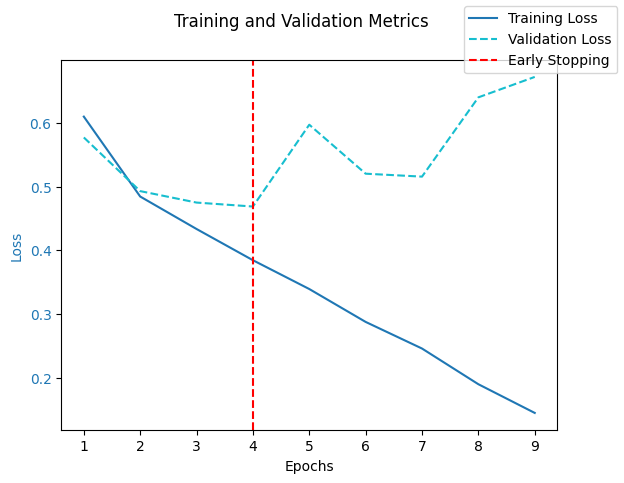


Training with seed 20
Early stopping at epoch 11.
Best Val F1: 0.8020.


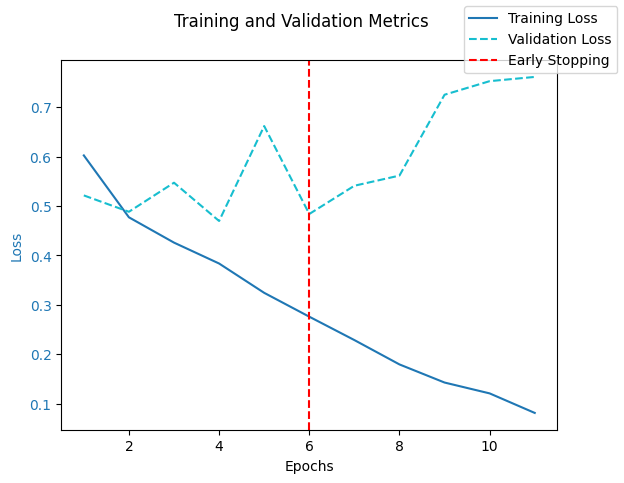


Training with seed 38
Early stopping at epoch 10.
Best Val F1: 0.7836.


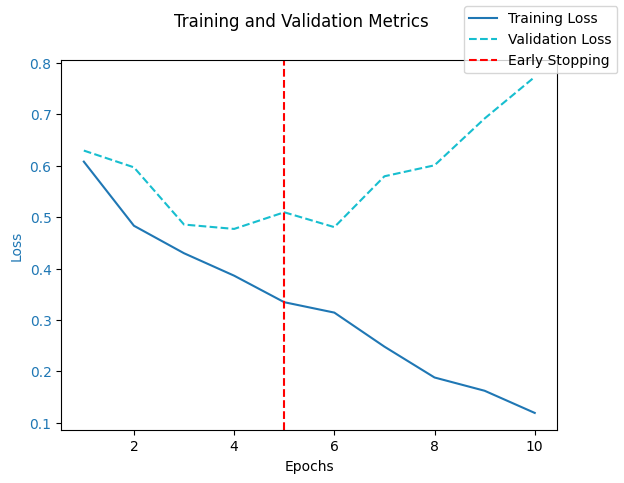


Training with seed 42
Early stopping at epoch 10.
Best Val F1: 0.7918.


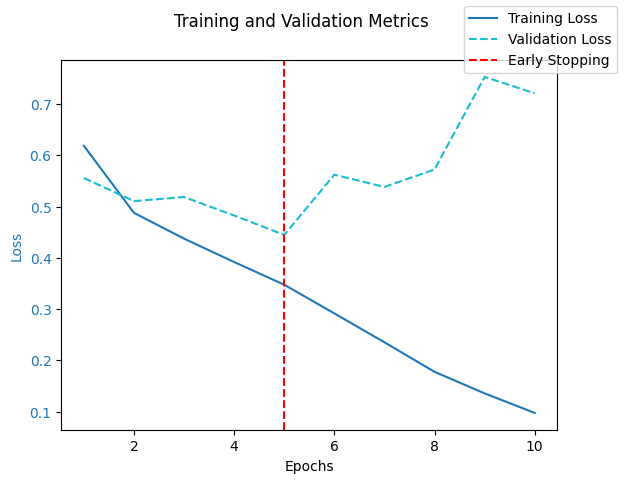


Training with seed 60
Early stopping at epoch 14.
Best Val F1: 0.8131.


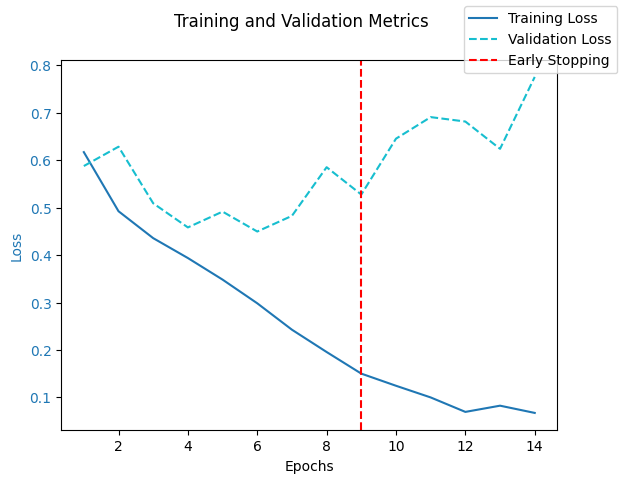

In [ ]:
#HYPERPAMETERS FOR THE BASELINE MODEL
hidden_size = 32
num_layers = 1
input_size = 200
output_size = 1
models_baseline = []
main_training(x_train, y_train, x_val, y_val, input_size, hidden_size, num_layers, output_size, embedding_dim, models_baseline,learning_rate,num_epochs,batch_size)

In [ ]:
evaluate_models(models_baseline, x_test, y_test, batch_size=128, device=device)

Model 1:
  Test Accuracy: 0.7657
  Test F1 Score: 0.7586

Model 2:
  Test Accuracy: 0.7448
  Test F1 Score: 0.7404

Model 3:
  Test Accuracy: 0.7692
  Test F1 Score: 0.7620

Model 4:
  Test Accuracy: 0.7378
  Test F1 Score: 0.7298

Model 5:
  Test Accuracy: 0.7378
  Test F1 Score: 0.7261

Average Accuracy: 0.7510
Average F1 Score: 0.7434

Standard Deviation Accuracy: 0.0137
Standard Deviation F1 Score: 0.0146



Training with seed 5
Layer                                    Parameters     
lstm.weight_ih_l0                        25600          
lstm.weight_hh_l0                        4096           
lstm.bias_ih_l0                          128            
lstm.bias_hh_l0                          128            
lstm.weight_ih_l0_reverse                25600          
lstm.weight_hh_l0_reverse                4096           
lstm.bias_ih_l0_reverse                  128            
lstm.bias_hh_l0_reverse                  128            
lstm.weight_ih_l1                        8192           
lstm.weight_hh_l1                        4096           
lstm.bias_ih_l1                          128            
lstm.bias_hh_l1                          128            
lstm.weight_ih_l1_reverse                8192           
lstm.weight_hh_l1_reverse                4096           
lstm.bias_ih_l1_reverse                  128            
lstm.bias_hh_l1_reverse                  128            
fc.weight

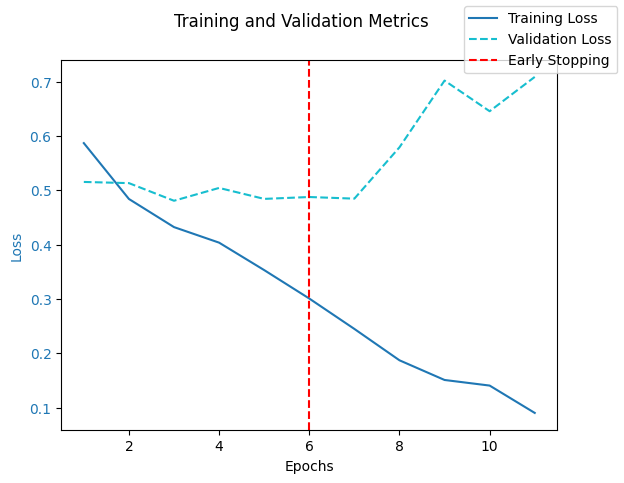


Training with seed 20
Early stopping at epoch 14.
Best Val F1: 0.8284.


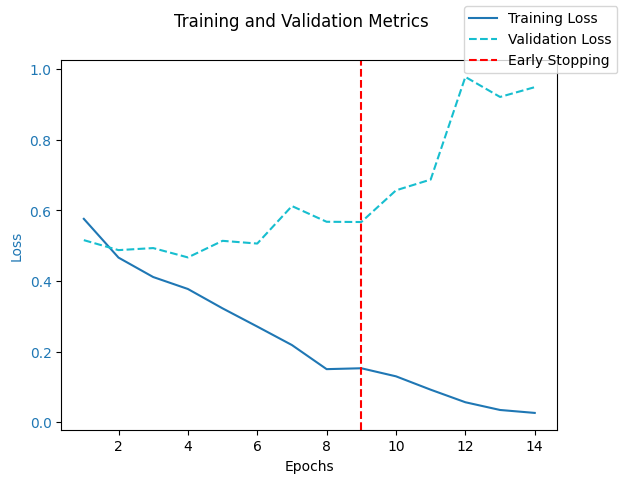


Training with seed 38
Early stopping at epoch 11.
Best Val F1: 0.8199.


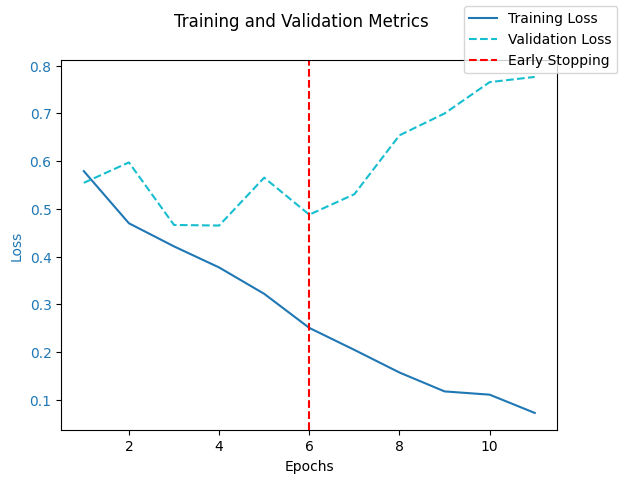


Training with seed 42
Early stopping at epoch 12.
Best Val F1: 0.8303.


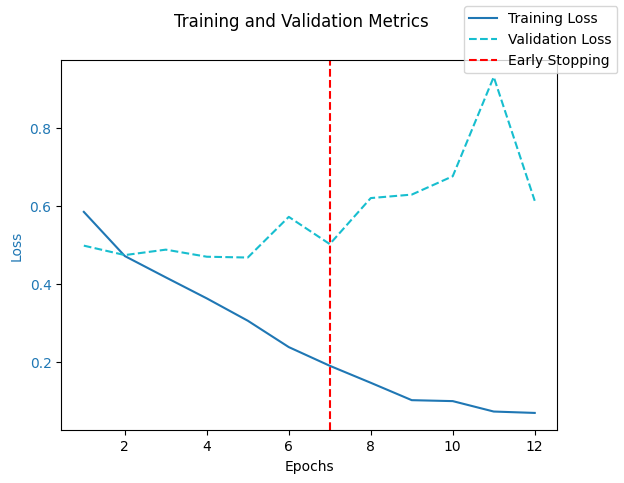


Training with seed 60
Early stopping at epoch 9.
Best Val F1: 0.8170.


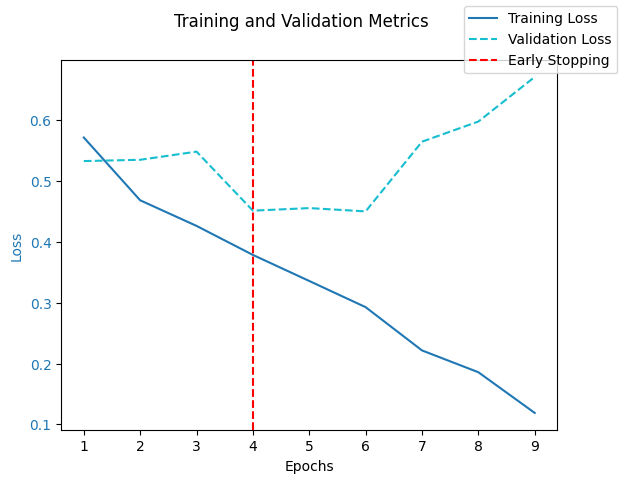

In [ ]:
#HYPERPARAMETER FOR THE MODEL_1
num_layers = 2
models_model1 = []
main_training(x_train, y_train, x_val, y_val, input_size, hidden_size, num_layers, output_size, embedding_dim,models_model1, learning_rate,num_epochs,batch_size)

In [ ]:
evaluate_models(models_model1, x_test, y_test, batch_size=128, device=device)

Model 1:
  Test Accuracy: 0.7483
  Test F1 Score: 0.7427

Model 2:
  Test Accuracy: 0.7413
  Test F1 Score: 0.7384

Model 3:
  Test Accuracy: 0.7622
  Test F1 Score: 0.7570

Model 4:
  Test Accuracy: 0.7552
  Test F1 Score: 0.7529

Model 5:
  Test Accuracy: 0.7692
  Test F1 Score: 0.7641

Average Accuracy: 0.7552
Average F1 Score: 0.7510

Standard Deviation Accuracy: 0.0099
Standard Deviation F1 Score: 0.0094


# [Task 8 - 0.5 points] Report

Wrap up your experiment in a short report (up to 2 pages).

### Instructions

* Use the NLP course report template.
* Summarize each task in the report following the provided template.

### Recommendations

The report is not a copy-paste of graphs, tables, and command outputs.

* Summarize classification performance in Table format.
* **Do not** report command outputs or screenshots.
* Report learning curves in Figure format.
* The error analysis section should summarize your findings.


# Submission

* **Submit** your report in PDF format.
* **Submit** your python notebook.
* Make sure your notebook is **well organized**, with no temporary code, commented sections, tests, etc...
* You can upload **model weights** in a cloud repository and report the link in the report.

# FAQ

Please check this frequently asked questions before contacting us

### Execution Order

You are **free** to address tasks in any order (if multiple orderings are available).

### Trainable Embeddings

You are **free** to define a trainable or non-trainable Embedding layer to load the GloVe embeddings.

### Model architecture

You **should not** change the architecture of a model (i.e., its layers).
However, you are **free** to play with their hyper-parameters.


### Neural Libraries

You are **free** to use any library of your choice to implement the networks (e.g., Keras, Tensorflow, PyTorch, JAX, etc...)

### Keras TimeDistributed Dense layer

If you are using Keras, we recommend wrapping the final Dense layer with `TimeDistributed`.

### Robust Evaluation

Each model is trained with at least 3 random seeds.

Task 4 requires you to compute the average performance over the 3 seeds and its corresponding standard deviation.

### Model Selection for Analysis

To carry out the error analysis you are **free** to either

* Pick examples or perform comparisons with an individual seed run model (e.g., Baseline seed 1337)
* Perform ensembling via, for instance, majority voting to obtain a single model.

### Error Analysis

Some topics for discussion include:
   * Precision/Recall curves.
   * Confusion matrices.
   * Specific misclassified samples.

### Bonus Points
Bonus points are arbitrarily assigned based on significant contributions such as:
- Outstanding error analysis
- Masterclass code organization
- Suitable extensions
Note that bonus points are only assigned if all task points are attributed (i.e., 6/6).

**Possible Extensions/Explorations for Bonus Points:**
- **Try other preprocessing strategies**: e.g., but not limited to, explore techniques tailored specifically for tweets or  methods that are common in social media text.
- **Experiment with other custom architectures or models from HuggingFace**
- **Explore Spanish tweets**: e.g., but not limited to, leverage multilingual models to process Spanish tweets and assess their performance compared to monolingual models.







# The End